In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from autogluon import TabularPrediction as task

import pylab as plt
import seaborn as sns
%matplotlib inline

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from neighbourhoods.lime_neigh import LimeNeigh
from neighbourhoods.shap_neigh import ShapNeigh

from sklearn import linear_model
from sklearn.metrics import accuracy_score


def autogluon_blackbox_predict_proba(ze):
    
    ze = pd.DataFrame(ze, columns=train_data.columns[:-1])
    return predictor.predict_proba(ze, as_multiclass=True)


def get_lime_neigh(ze, blackbox, neigh_size=100):
    
    xpl = LimeNeigh(neighbourhood_size=neighbourhood_size).fit(ze, blackbox)
    neigh, weights = xpl.get_neigh(ze)
    
    neigh = pd.DataFrame(neigh, columns=train_data.columns[:-1])
    
    return neigh, weights


def get_shap_neigh(ze, train_data, blackbox, neigh_size=100):
       
    xpl = ShapNeigh(neigh_size)
    xpl.fit(train_data, blackbox)
    neigh, weights = xpl.get_neigh(ze)
    
    neigh = pd.DataFrame(neigh, columns=train_data.columns)
    
    return neigh, weights

    
def get_blackboxes_predictions(blackboxes, neigh, included_blackboxes=None):
    """
    blackboxes: autogluon predictor
    """

    preds = {}
    for p in blackboxes.get_model_names():
        
        if (included_blackboxes is None) or (p in included_blackboxes):
            ypred = blackboxes.predict(neigh, model=p)
            preds[p] = ypred
        
    preds = pd.DataFrame(preds)
    return preds

def fit_surrogates(neigh, ypreds_neigh):
    
    surrogates = {}
    fi = {}

    for p in ypreds_neigh.columns:

        # For lime should be a regressor on proba?
        reg = linear_model.RidgeClassifier(alpha=1)
        reg.fit(neigh, ypreds_neigh.loc[:,p])
        surrogates[p] = reg
        fi[p] = pd.Series(reg.coef_[0], index=neigh.columns)

    fi = pd.DataFrame(fi)
    
    return surrogates, fi

def get_to_k_features_across_blackboxes(fi, top_k_features=5):
    
    rank_fi = fi.abs().rank(axis=0, method='min')
    # Remove ranking from blackboxes where all features are equally equal (assumption: surrogate cannot be fitted properly on the neighbourhood, e.g. same class for all instances)
    ucols = utils.unique_cols(rank_fi)
    rank_fi = (rank_fi.loc[:,ucols]<top_k_features).sum(axis=1)
    rank_fi = rank_fi[rank_fi != 0]
    includes_features = rank_fi.index
    
    return includes_features

def get_surrogate_fidelity(surrogates, neigh, ypreds_neigh):
    
    fidelities = {}
    for s in surrogates.keys():
        ypreds_surr = surrogates[s].predict(neigh)
        
        fidelities[s] = accuracy_score(ypreds_neigh.loc[:,s], ypreds_surr)
        
    return pd.Series(fidelities, name='Surrogate fidelities')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer, make_moons

data = load_breast_cancer(return_X_y=False)

X = data.data
y = data.target.reshape(len(data.target),-1)

X = np.concatenate((X, y), axis=1)
fnames = np.concatenate((data.feature_names, ['class']))


""" Half-moons """
X, y = make_moons(n_samples=300, noise=0.3, random_state=0)
X = StandardScaler().fit_transform(X)
X = np.concatenate((X, y.reshape(len(y),-1)), axis=1)
fnames = ['Feature 1', 'Feature 2', 'class']


df = pd.DataFrame(data=X, columns=fnames)

train_data, test_data, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

In [7]:
predictor = task.fit(train_data=train_data, time_limits=10, label='class', refit_full=True)
performance = predictor.evaluate(test_data)

predictor.leaderboard(test_data, silent=True)

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200929_133238/
Beginning AutoGluon training ... Time limit = 10s
AutoGluon will save models to AutogluonModels/ag-20200929_133238/
AutoGluon Version:  0.0.13
Train Data Rows:    201
Train Data Columns: 3
Preprocessing data ...
Here are the 2 unique label values in your data:  [0.0, 1.0]
AutoGluon infers your prediction problem is: binary  (because only two unique label-values observed).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Sel

Predictive performance on given dataset: accuracy = 0.898989898989899


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestClassifierGini_FULL,0.949495,NaN,0.032090,NaN,0.361576,0.032090,NaN,0.361576,0,True,10
1,KNeighborsClassifierDist,0.939394,0.926829,0.005033,0.006912,0.001267,0.005033,0.006912,0.001267,0,True,6
2,KNeighborsClassifierUnif,0.929293,0.902439,0.004712,0.006734,0.001470,0.004712,0.006734,0.001470,0,True,5
3,ExtraTreesClassifierGini_FULL,0.929293,NaN,0.036329,NaN,0.275746,0.036329,NaN,0.275746,0,True,12
4,ExtraTreesClassifierEntr_FULL,0.929293,NaN,0.038503,NaN,0.263741,0.038503,NaN,0.263741,0,True,13
5,CatboostClassifier_FULL,0.919192,NaN,0.002219,NaN,0.041352,0.002219,NaN,0.041352,0,True,16
6,weighted_ensemble_FULL_k0_l1,0.919192,NaN,0.003919,NaN,0.043000,0.001700,NaN,0.001648,1,True,18
7,KNeighborsClassifierDist_FULL,0.919192,NaN,0.004573,NaN,0.000930,0.004573,NaN,0.000930,0,True,15
8,RandomForestClassifierEntr_FULL,0.919192,NaN,0.036939,NaN,0.346951,0.036939,NaN,0.346951,0,True,11
9,KNeighborsClassifierUnif_FULL,0.909091,NaN,0.004553,NaN,0.001902,0.004553,NaN,0.001902,0,True,14


In [8]:
ze = test_data.iloc[[10],:-1].to_numpy()  
neighbourhood_size = 100

included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values

neigh, weights = get_lime_neigh(ze, autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
surrogates, fi = fit_surrogates(neigh, ypreds_neigh)

# Prediction agreement, feature importance ranking (pos/neg), feature importance comparison
# Accuracy of the blackbox on the neigh
print(get_surrogate_fidelity(surrogates, neigh, ypreds_neigh))

includes_features = get_to_k_features_across_blackboxes(fi, top_k_features=5)

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KNeighborsClassifierUnif           0.78
KNeighborsClassifierDist           0.74
RandomForestClassifierGini_FULL    0.80
ExtraTreesClassifierGini_FULL      0.80
ExtraTreesClassifierEntr_FULL      0.80
CatboostClassifier_FULL            0.79
weighted_ensemble_FULL_k0_l1       0.79
Name: Surrogate fidelities, dtype: float64


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.251868
1         KNeighborsClassifierUnif  Feature 2           -0.632713
2         KNeighborsClassifierDist  Feature 1            0.200350
3         KNeighborsClassifierDist  Feature 2           -0.616945
4  RandomForestClassifierGini_FULL  Feature 1            0.155730


/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


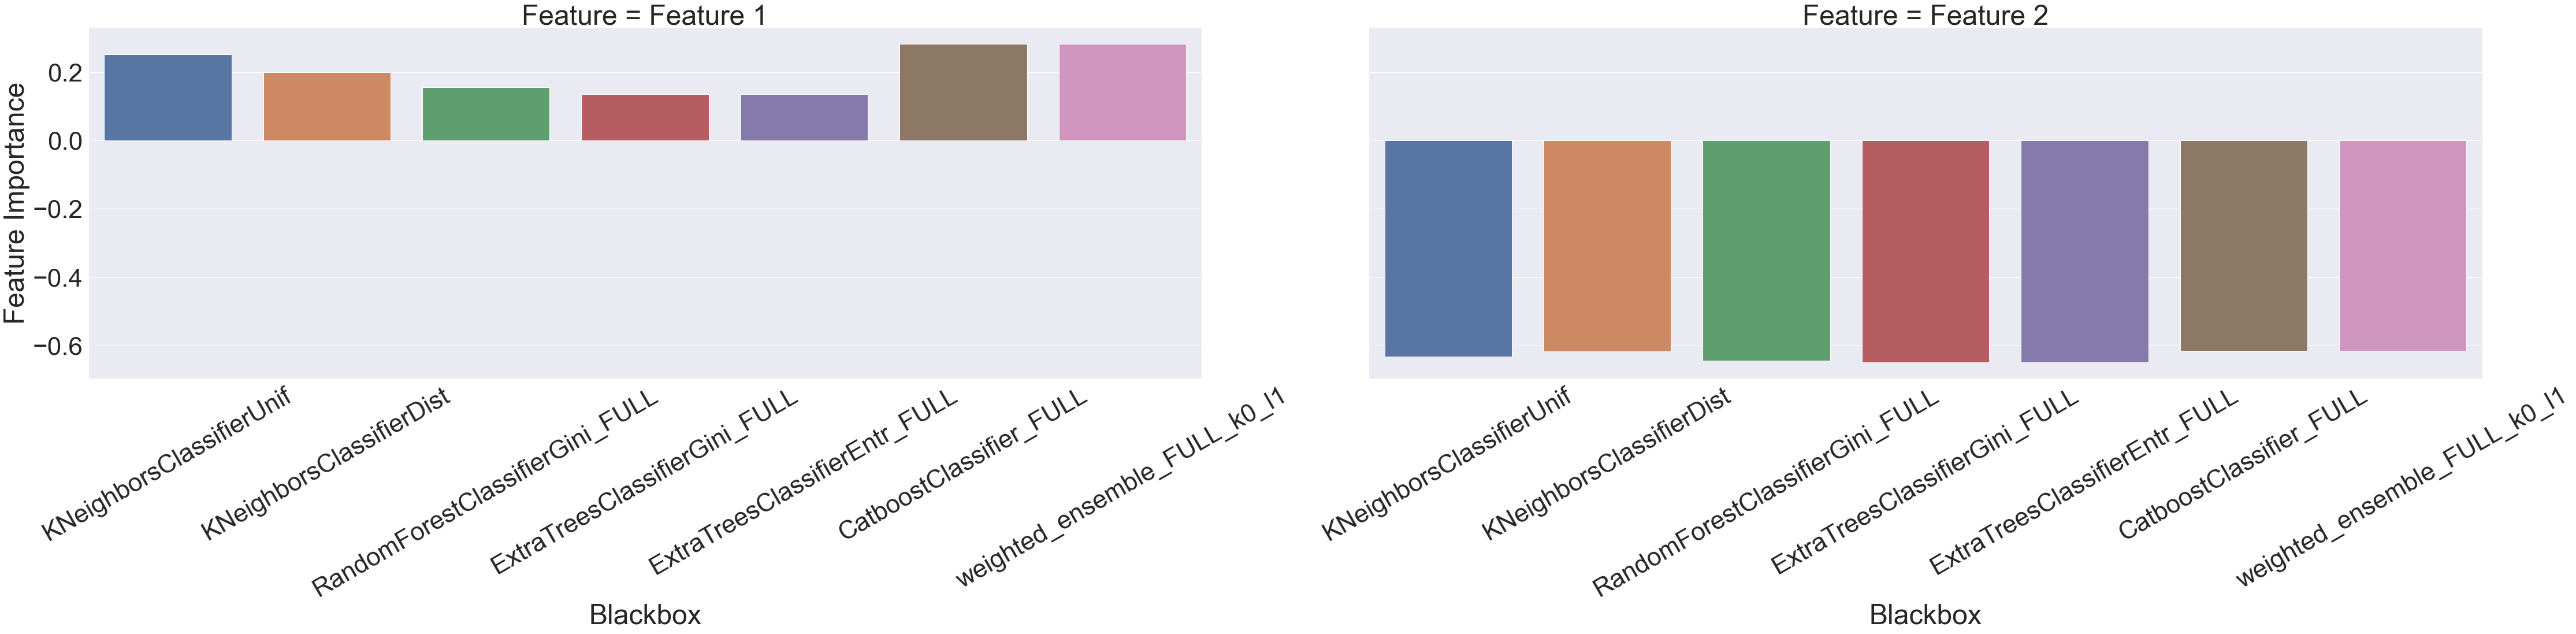

In [9]:
fi_unstacked = utils.plot_feature_importances_by_blackbox(fi)

In [10]:
x_min = X[:,0].min()
x_max = X[:,0].max()
y_min = X[:,1].min()
y_max = X[:,1].max()
x_step = y_step = 0.005

x = np.arange(x_min, x_max, x_step)
y = np.arange(y_min, y_max, y_step)
xx, yy = np.meshgrid(x, y)

X_tmp = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1)
X_tmp = pd.DataFrame(X_tmp)
X_tmp.columns = ['Feature 1', 'Feature 2']

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


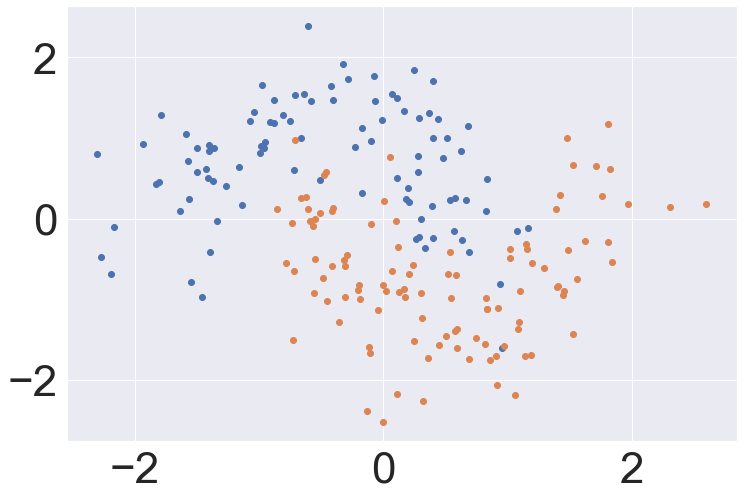

In [11]:
plt.figure(figsize=(12,8))

plt.scatter(train_data[y_train==0].iloc[:,0], train_data[y_train==0].iloc[:,1])
plt.scatter(train_data[y_train==1].iloc[:,0], train_data[y_train==1].iloc[:,1])


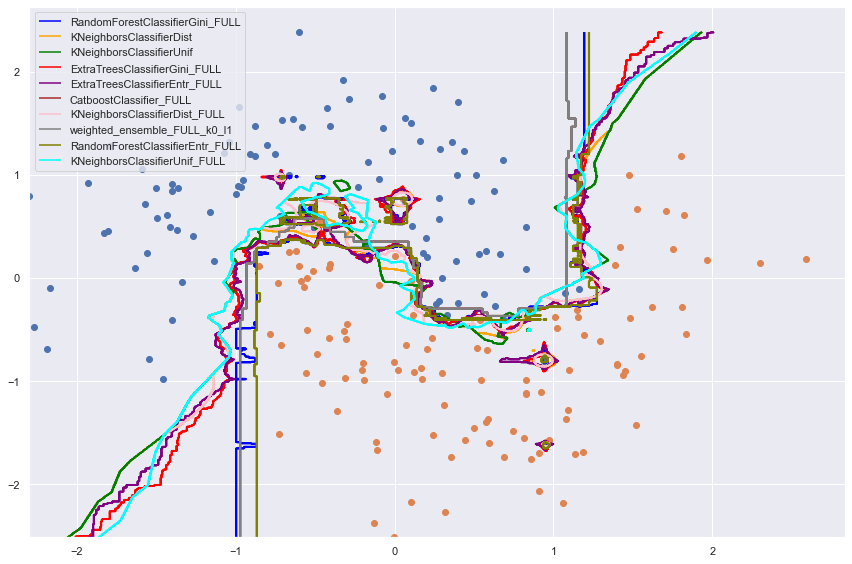

In [17]:
sns.set_context('notebook')

plt.figure(figsize=(12,8))

plt.scatter(train_data[y_train==0].iloc[:,0], train_data[y_train==0].iloc[:,1])
plt.scatter(train_data[y_train==1].iloc[:,0], train_data[y_train==1].iloc[:,1])

models_ranked = [m for m in predictor.leaderboard(test_data, silent=True).loc[:9,'model']]

plots = []
i = 0
for p in models_ranked:
    preds = predictor.predict(X_tmp, model=p)
    preds = preds.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds, colors=colors[i])
    plots.append(tmp)
    i += 1
    

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, models_ranked, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.tight_layout()

In [104]:
for ze in test_data.iloc[::10,:-1]:

ze = test_data.iloc[[10],:-1].to_numpy()  
neighbourhood_size = 100

included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values

neigh, weights = get_lime_neigh(ze, autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
surrogates, fi = fit_surrogates(neigh, ypreds_neigh)

# Prediction agreement, feature importance ranking (pos/neg), feature importance comparison
# Accuracy of the blackbox on the neigh
print(get_surrogate_fidelity(surrogates, neigh, ypreds_neigh))

includes_features = get_to_k_features_across_blackboxes(fi, top_k_features=5)

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.169104
1         KNeighborsClassifierUnif  Feature 2           -0.678617
2         KNeighborsClassifierDist  Feature 1            0.164304
3         KNeighborsClassifierDist  Feature 2           -0.673082
4  RandomForestClassifierGini_FULL  Feature 1            0.197107
                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.185689
1         KNeighborsClassifierUnif  Feature 2           -0.550103
2         KNeighborsClassifierDist  Feature 1            0.178513
3         KNeighborsClassifierDist  Feature 2           -0.581787
4  RandomForestClassifierGini_FULL  Feature 1            0.303749
                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.312933
1         KNeighborsClassifierUnif  Feature 2           -0.650175
2         

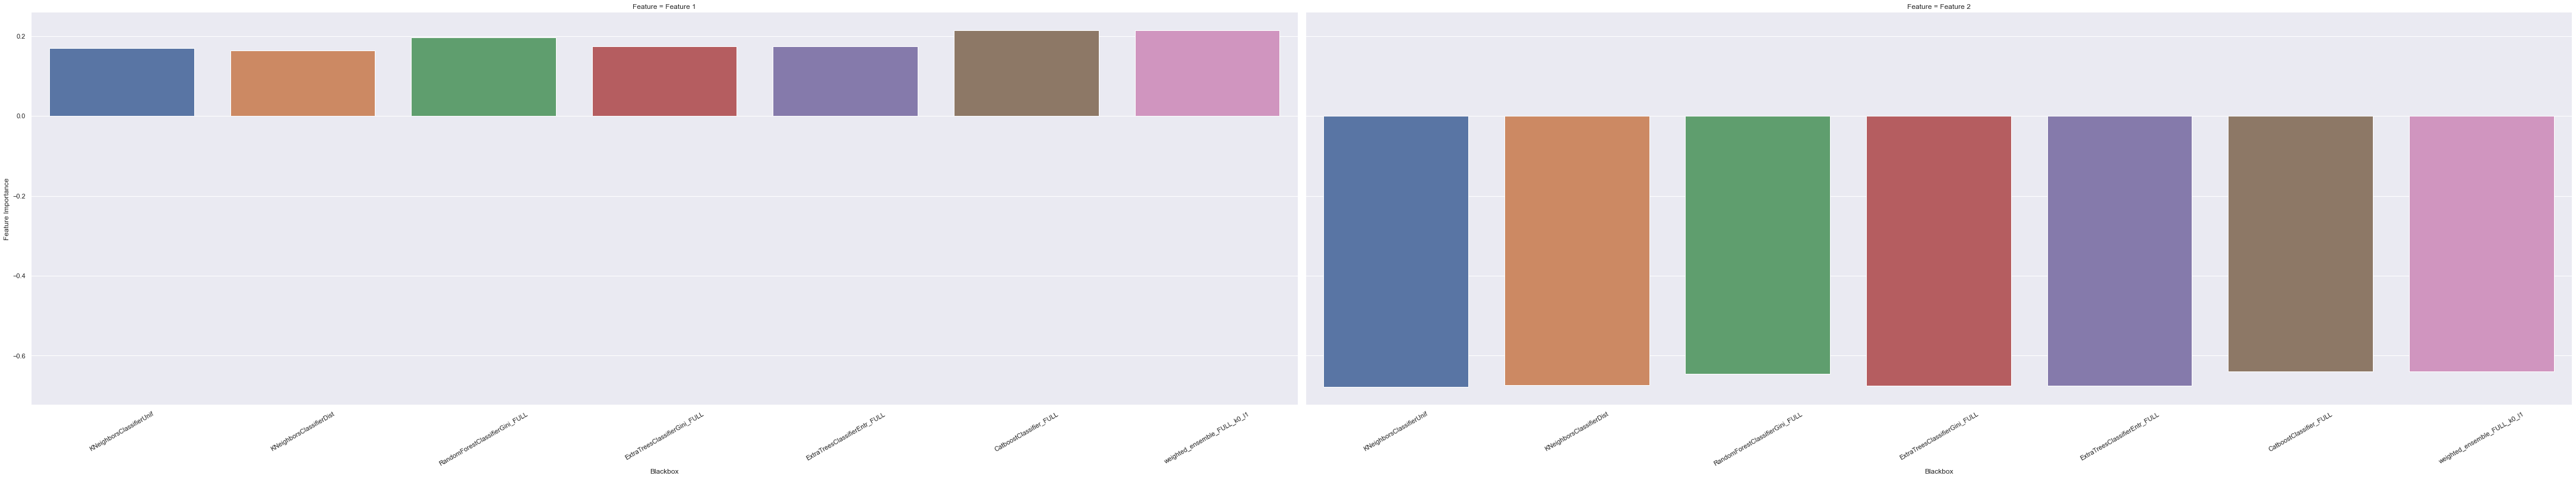

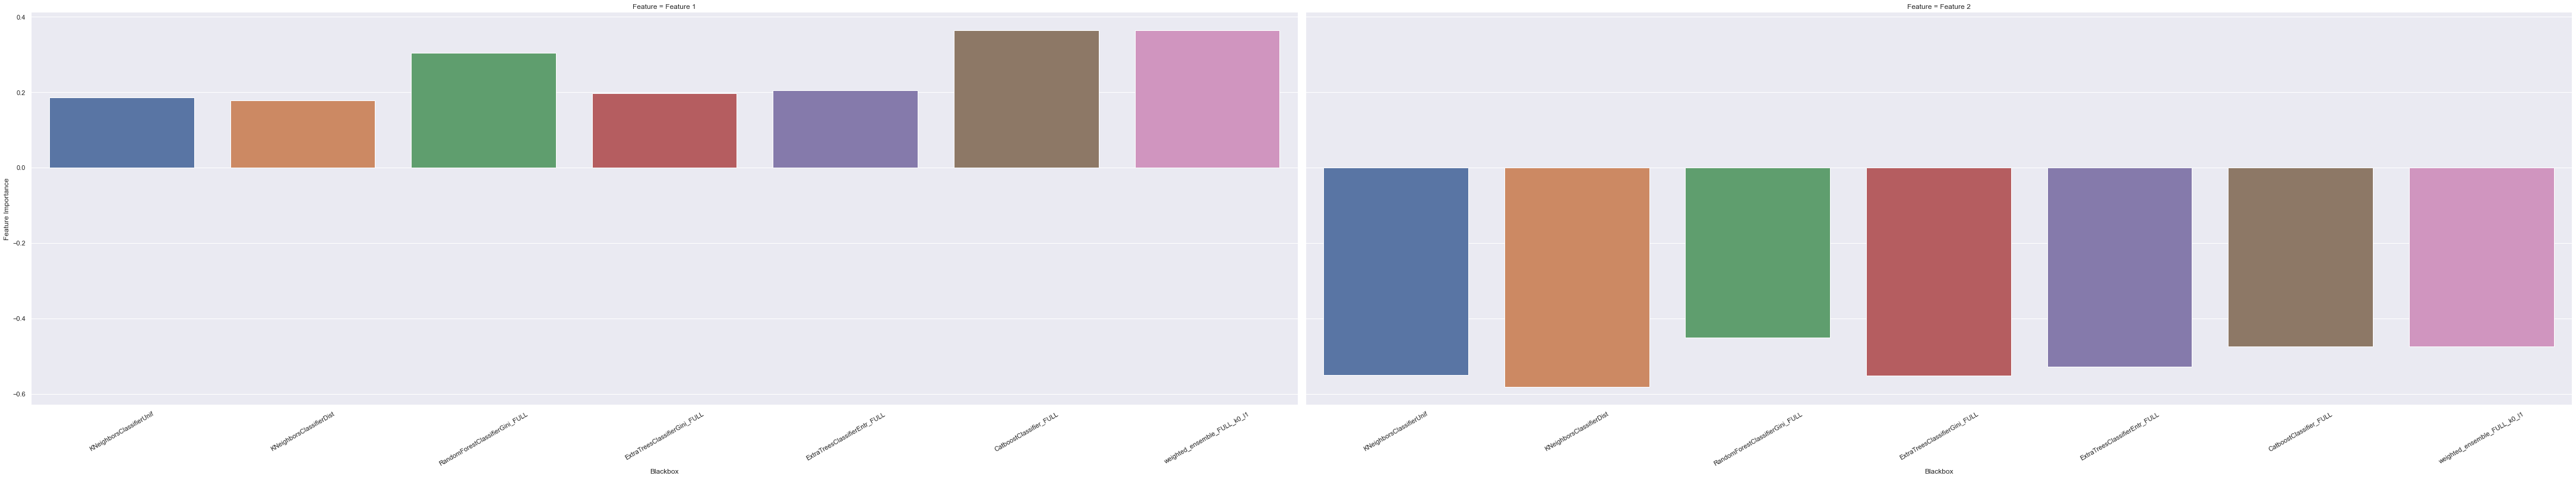

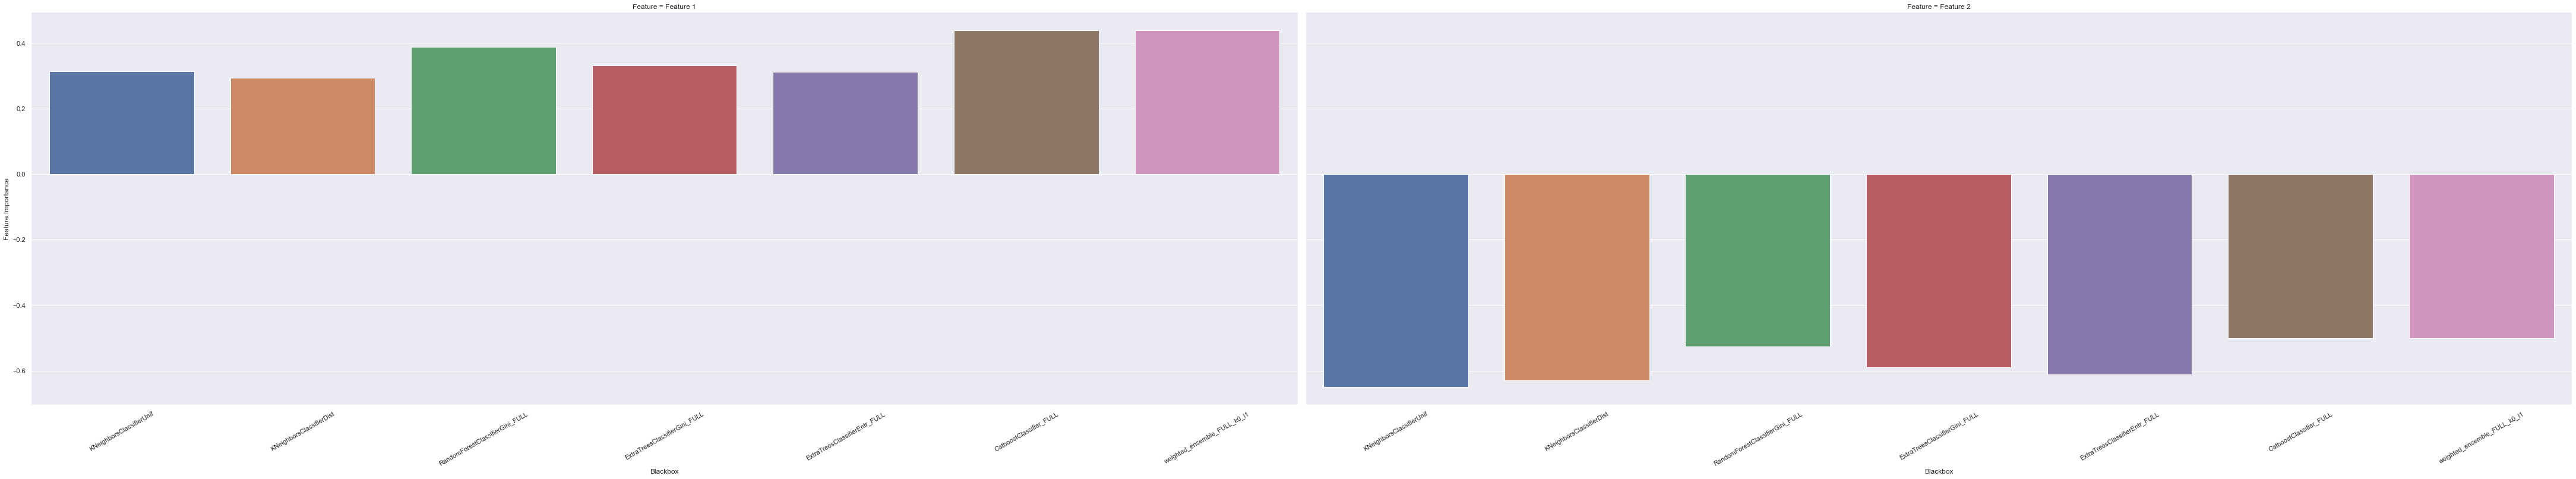

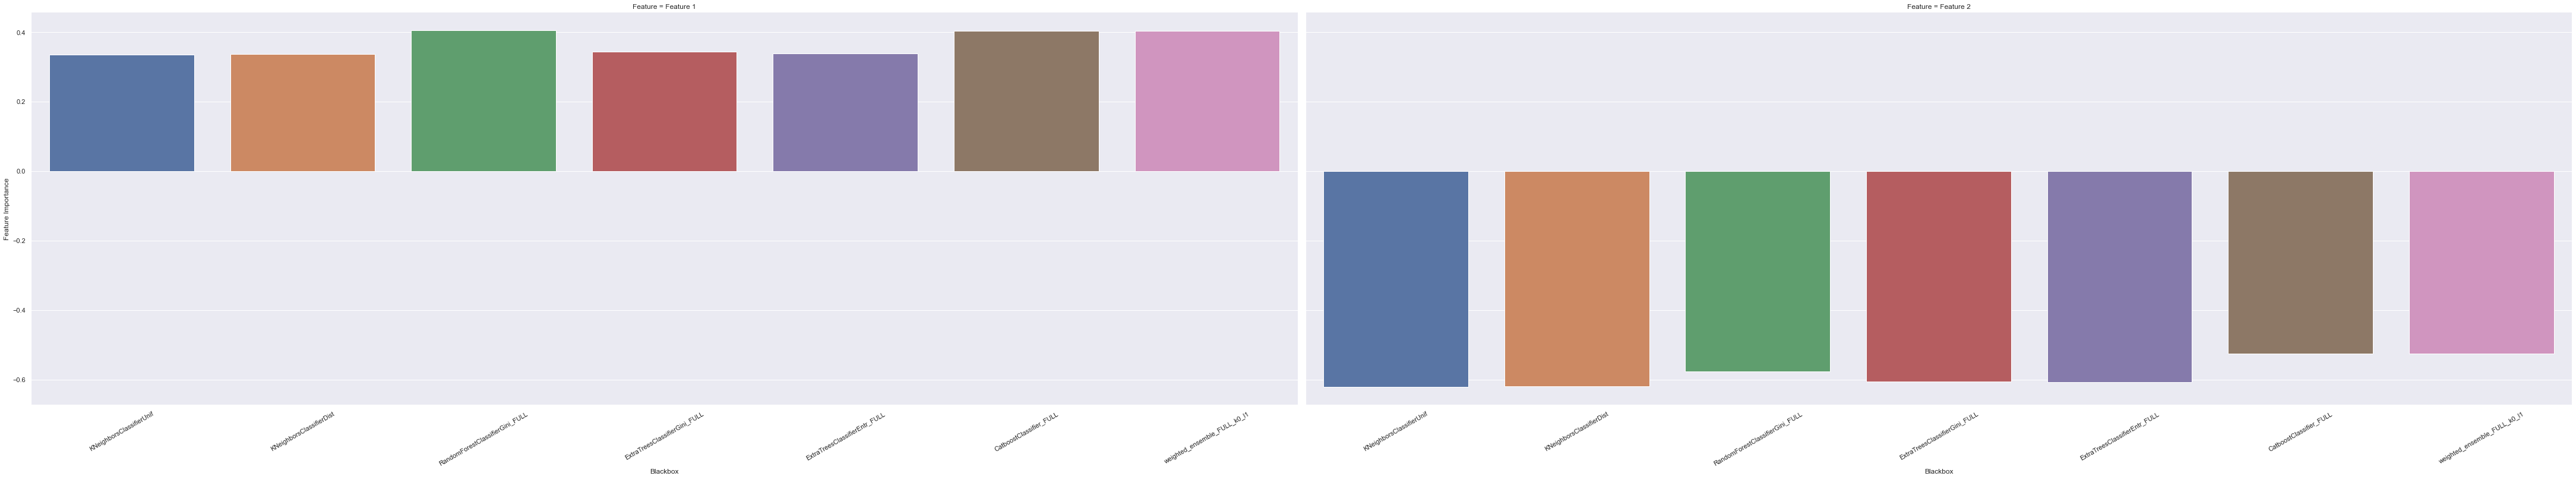

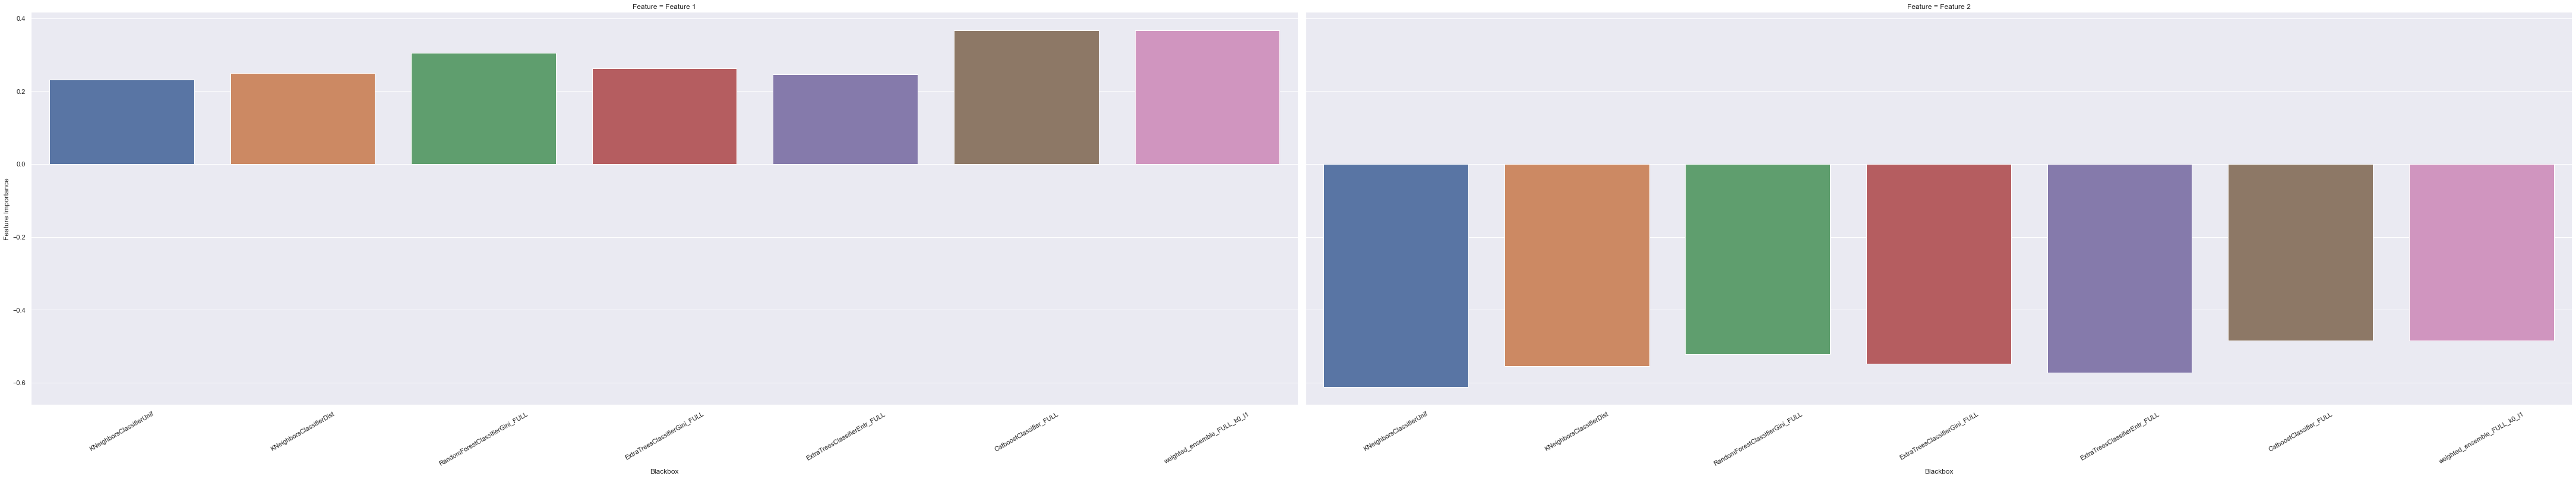

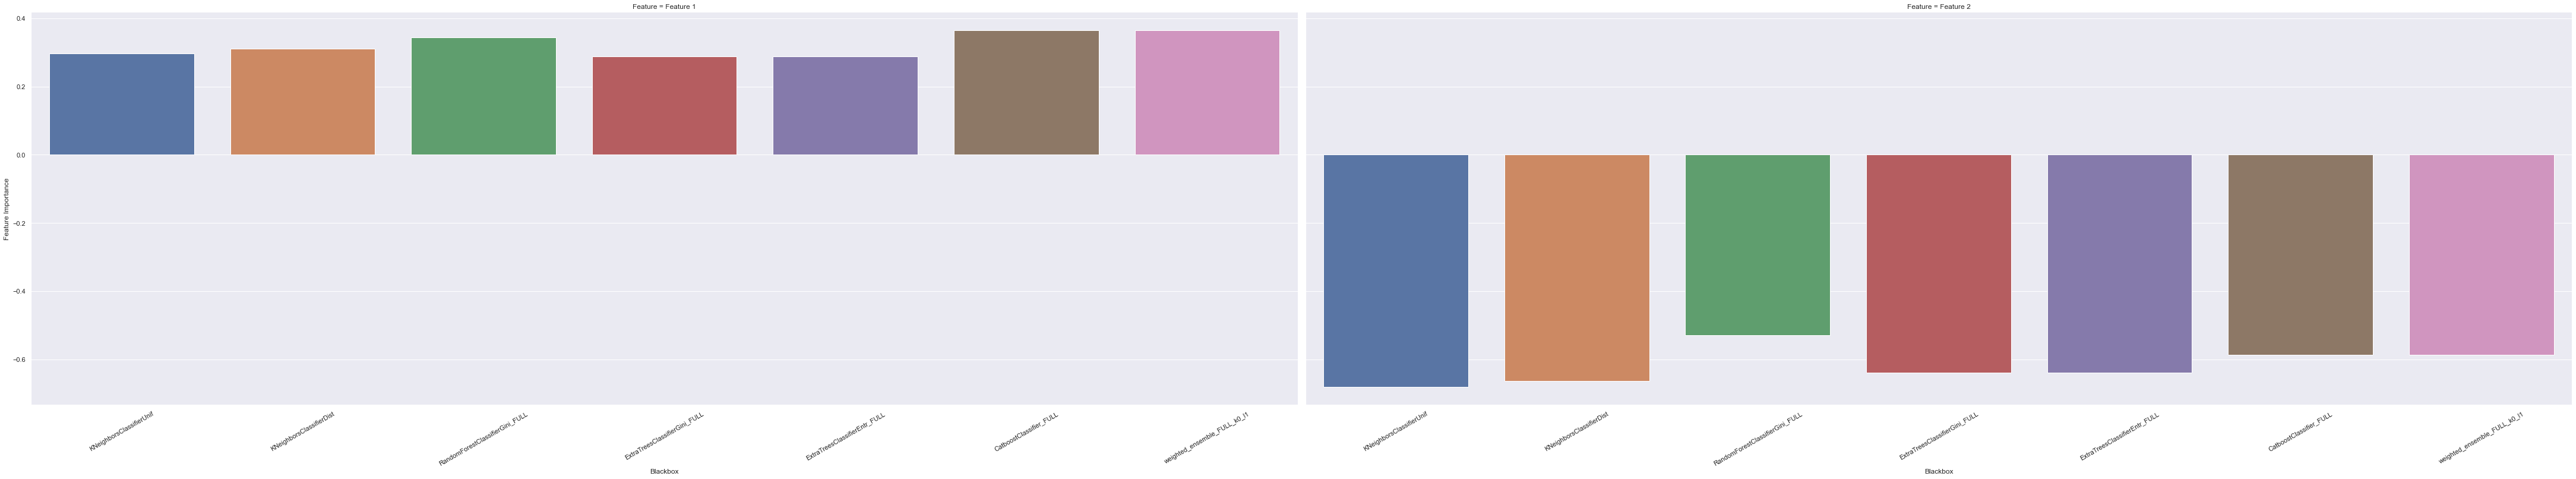

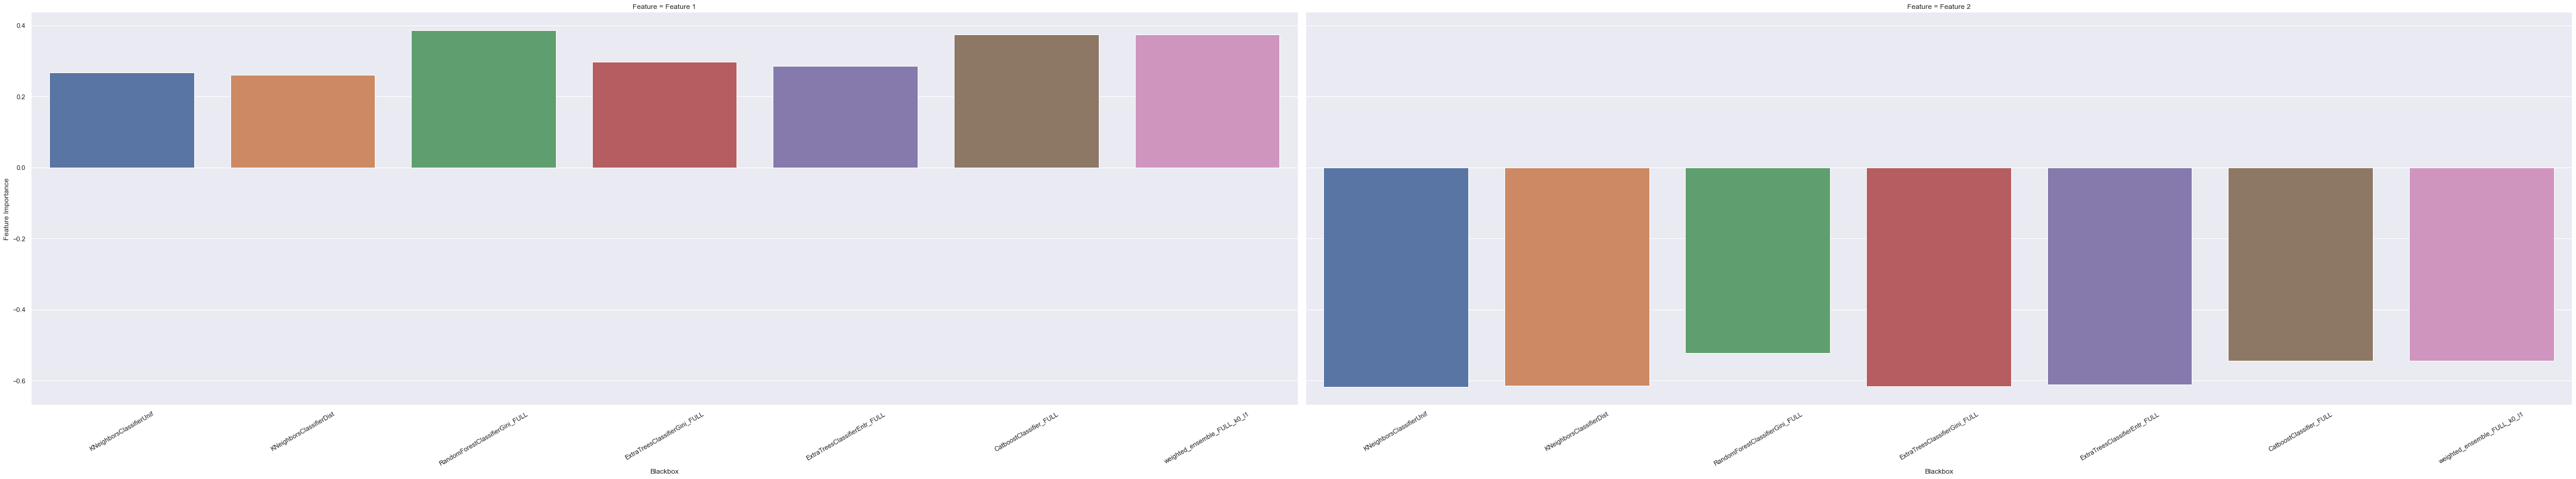

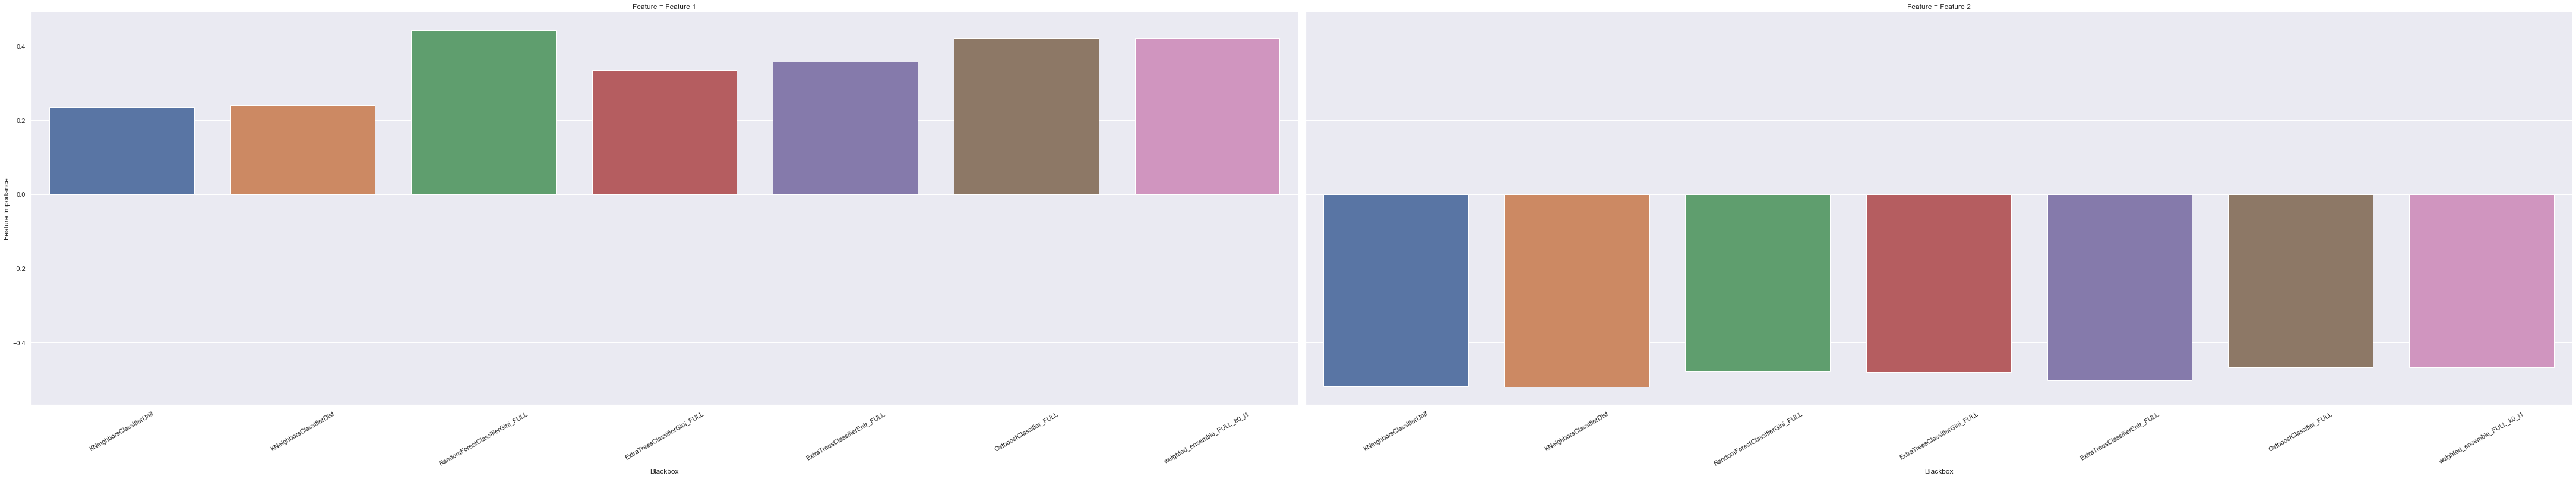

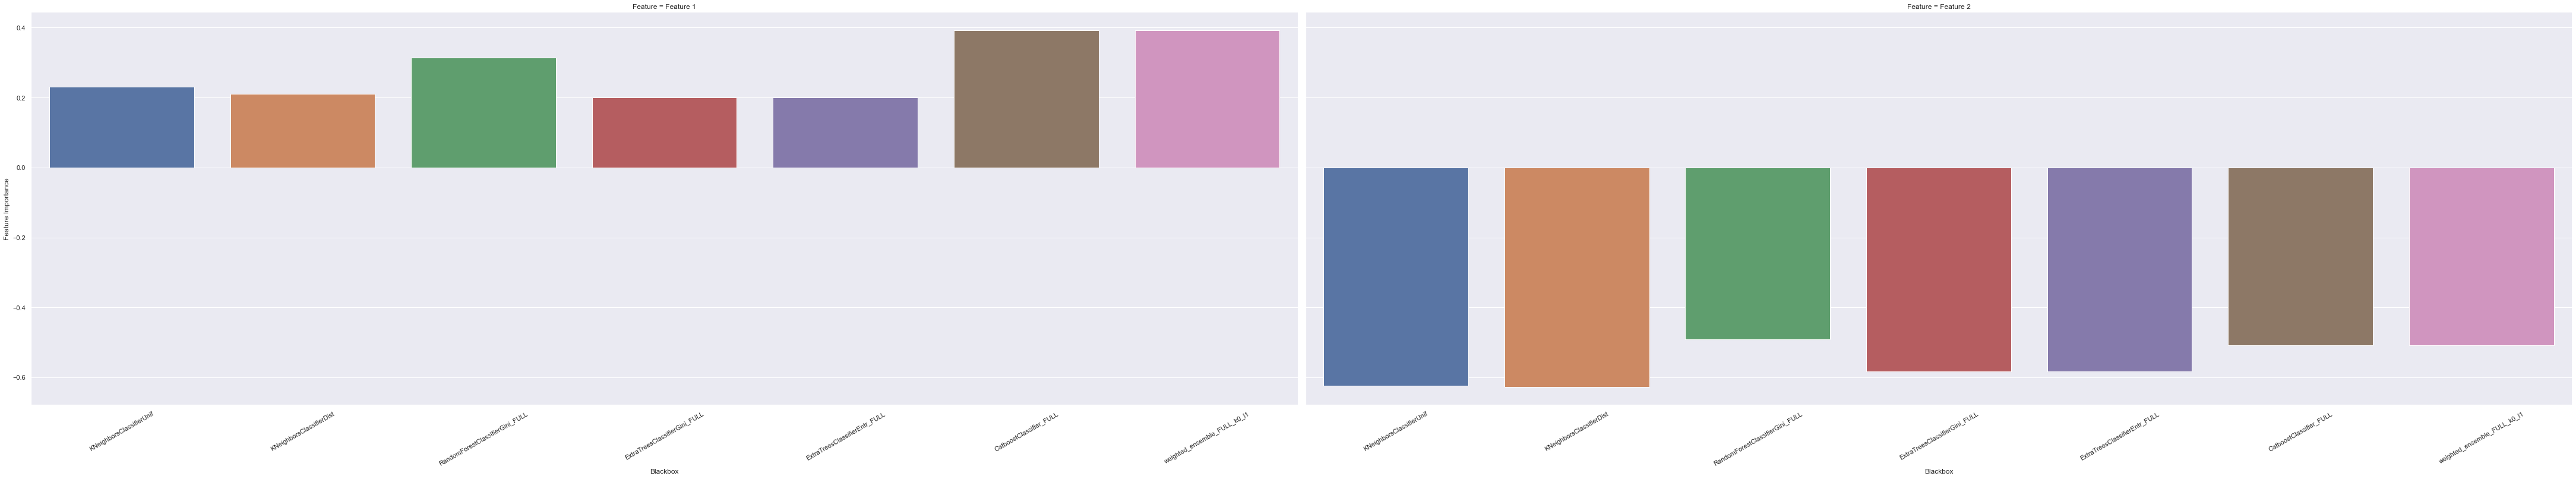

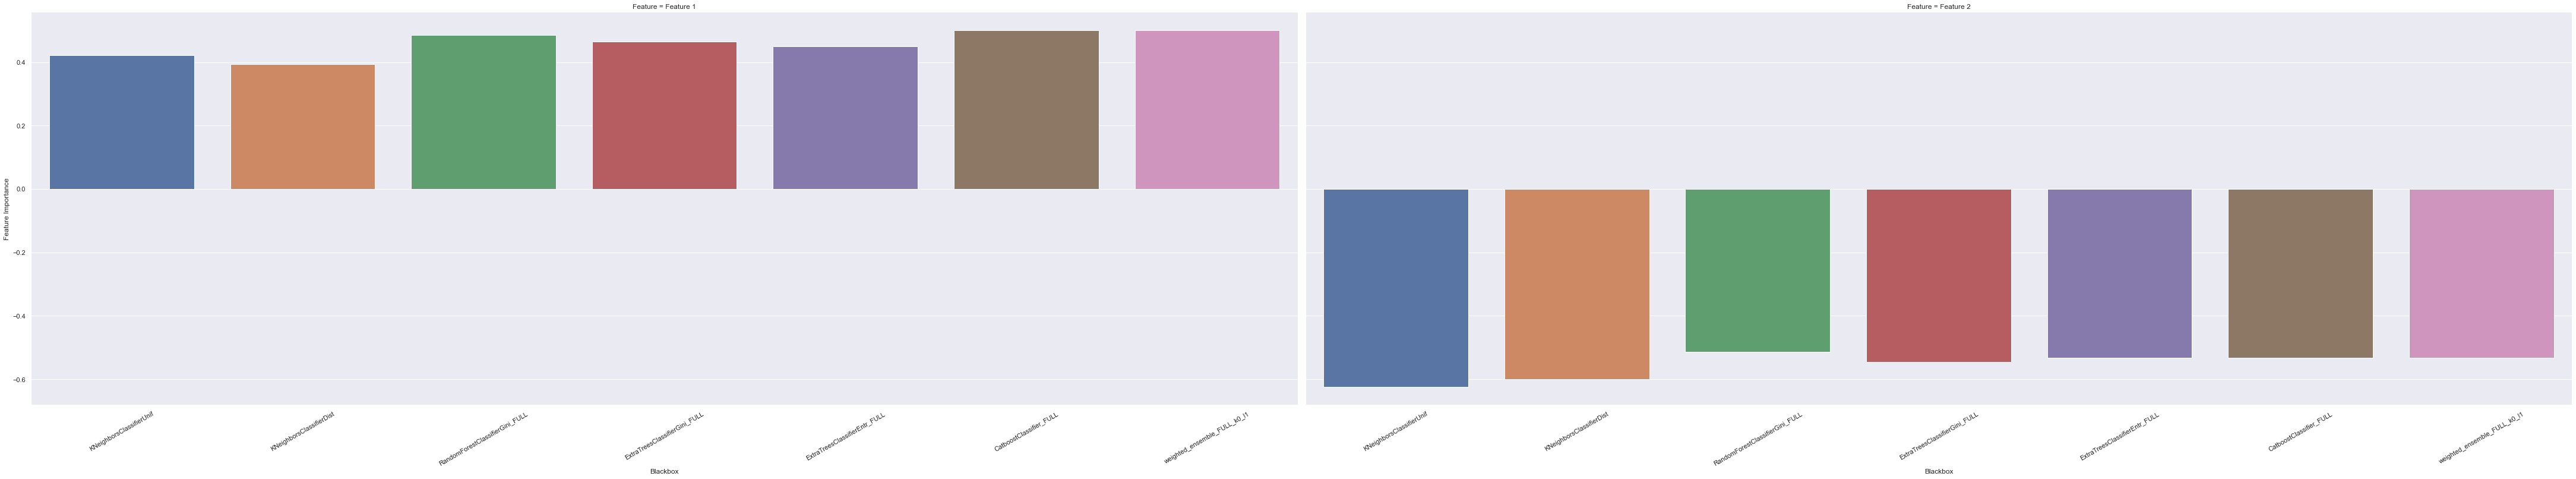

In [35]:
neighbourhood_size = 100
included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values

fis = {}

for ze in test_data.iloc[::10,:-1].iterrows():
    n_ze = ze[0]
    ze = (ze[1].to_frame().T).to_numpy()
    
    neigh, weights = get_lime_neigh(ze, autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
    ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
    surrogates, fi = fit_surrogates(neigh, ypreds_neigh)
    
    fi_unstacked = utils.plot_feature_importances_by_blackbox(fi)
    
    fis[n_ze] = fi_unstacked

In [79]:
def plot_feature_importances_by_blackbox(fi, k_features=None, kind='catplot', includes_features=None, colors=None, ax=None):

    if includes_features is not None:
        fi = fi.loc[includes_features]
        
    fi_unstacked = fi.unstack().reset_index(level=[0,1])
    fi_unstacked.columns = ['Blackbox', 'Feature', 'Feature Importance']
    print(fi_unstacked.head())

    if kind=='catplot':
        
        g = sns.catplot(
            data=fi_unstacked, kind="bar",
            y="Feature Importance", x="Blackbox",
            height=10, aspect=3, col='Feature', col_wrap=3, palette=colors, ax=ax
        )
        g.set_xticklabels(rotation=30)
        
    elif kind=='':
        pass
        
    return fi_unstacked

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sns.set_context('notebook')

neighbourhood_size = 100
included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values

fis = {}

for ze in test_data.iloc[::100,:-1].iterrows():
    n_ze = ze[0]
    ze = (ze[1].to_frame().T).to_numpy()
    
    plt.figure(figsize=(12,8))
    plt.scatter(train_data[y_train==0].iloc[:,0], train_data[y_train==0].iloc[:,1])
    plt.scatter(train_data[y_train==1].iloc[:,0], train_data[y_train==1].iloc[:,1])
    
    ###### Plot Models ########################################################################################
    plots = []
    i = 0
    for p in included_blackboxes:
        preds = predictor.predict(X_tmp, model=p)
        preds = preds.reshape((xx.shape[0], yy.shape[1]))
        tmp = plt.contour(xx, yy, preds, colors=colors[i])
        plots.append(tmp)
        i += 1
    
    contours = [p.legend_elements()[0][0] for p in plots]
    plt.legend(contours, models_ranked, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    ############################################################################################################
    
    plt.scatter(ze[0,0], ze[0,1], c='r', marker='*', s=200)
    
    neigh, weights = get_shap_neigh(ze, train_data.iloc[:,:-1], autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
    ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
    surrogates, fi = fit_surrogates(neigh, ypreds_neigh)
    
    fi_unstacked = utils.plot_feature_importances_by_blackbox(fi, colors=colors)
    
    fis[n_ze] = fi_unstacked

num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.160842
1         KNeighborsClassifierUnif  Feature 2           -0.788574
2         KNeighborsClassifierDist  Feature 1            0.162243
3         KNeighborsClassifierDist  Feature 2           -0.791859
4  RandomForestClassifierGini_FULL  Feature 1            0.209967


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.357201
1         KNeighborsClassifierUnif  Feature 2           -0.478851
2         KNeighborsClassifierDist  Feature 1            0.362559
3         KNeighborsClassifierDist  Feature 2           -0.387860
4  RandomForestClassifierGini_FULL  Feature 1            0.351156


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.361594
1         KNeighborsClassifierUnif  Feature 2           -0.527495
2         KNeighborsClassifierDist  Feature 1            0.377415
3         KNeighborsClassifierDist  Feature 2           -0.502061
4  RandomForestClassifierGini_FULL  Feature 1            0.409218


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.407771
1         KNeighborsClassifierUnif  Feature 2           -0.477863
2         KNeighborsClassifierDist  Feature 1            0.400660
3         KNeighborsClassifierDist  Feature 2           -0.418486
4  RandomForestClassifierGini_FULL  Feature 1            0.350100


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.335205
1         KNeighborsClassifierUnif  Feature 2           -0.506174
2         KNeighborsClassifierDist  Feature 1            0.375085
3         KNeighborsClassifierDist  Feature 2           -0.461654
4  RandomForestClassifierGini_FULL  Feature 1            0.425912


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.411547
1         KNeighborsClassifierUnif  Feature 2           -0.533438
2         KNeighborsClassifierDist  Feature 1            0.411519
3         KNeighborsClassifierDist  Feature 2           -0.472440
4  RandomForestClassifierGini_FULL  Feature 1            0.362601


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.275846
1         KNeighborsClassifierUnif  Feature 2           -0.860449
2         KNeighborsClassifierDist  Feature 1            0.289815
3         KNeighborsClassifierDist  Feature 2           -0.839991
4  RandomForestClassifierGini_FULL  Feature 1            0.348027


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.452007
1         KNeighborsClassifierUnif  Feature 2           -0.002589
2         KNeighborsClassifierDist  Feature 1            0.399539
3         KNeighborsClassifierDist  Feature 2           -0.002430
4  RandomForestClassifierGini_FULL  Feature 1            0.425362


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.402751
1         KNeighborsClassifierUnif  Feature 2           -0.546580
2         KNeighborsClassifierDist  Feature 1            0.404761
3         KNeighborsClassifierDist  Feature 2           -0.568860
4  RandomForestClassifierGini_FULL  Feature 1            0.457772


num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.341611
1         KNeighborsClassifierUnif  Feature 2           -0.382278
2         KNeighborsClassifierDist  Feature 1            0.346986
3         KNeighborsClassifierDist  Feature 2           -0.379462
4  RandomForestClassifierGini_FULL  Feature 1            0.352566


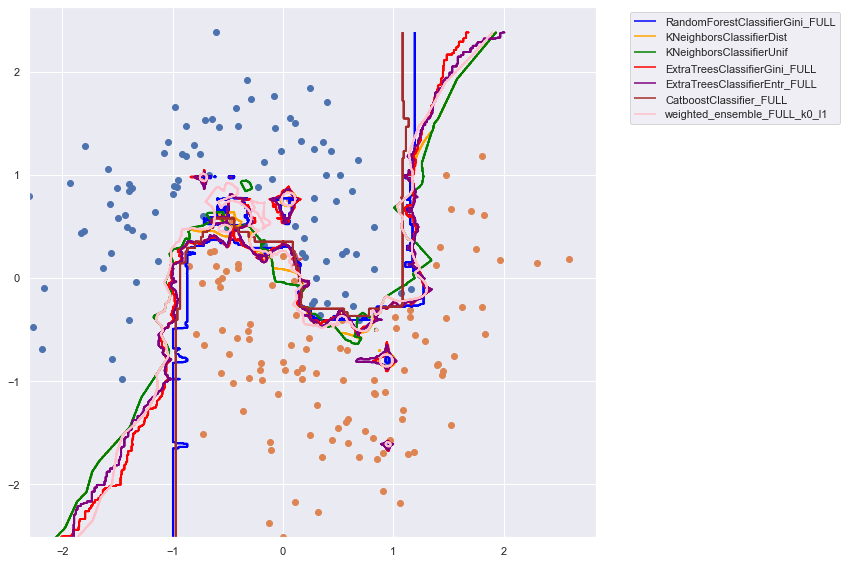

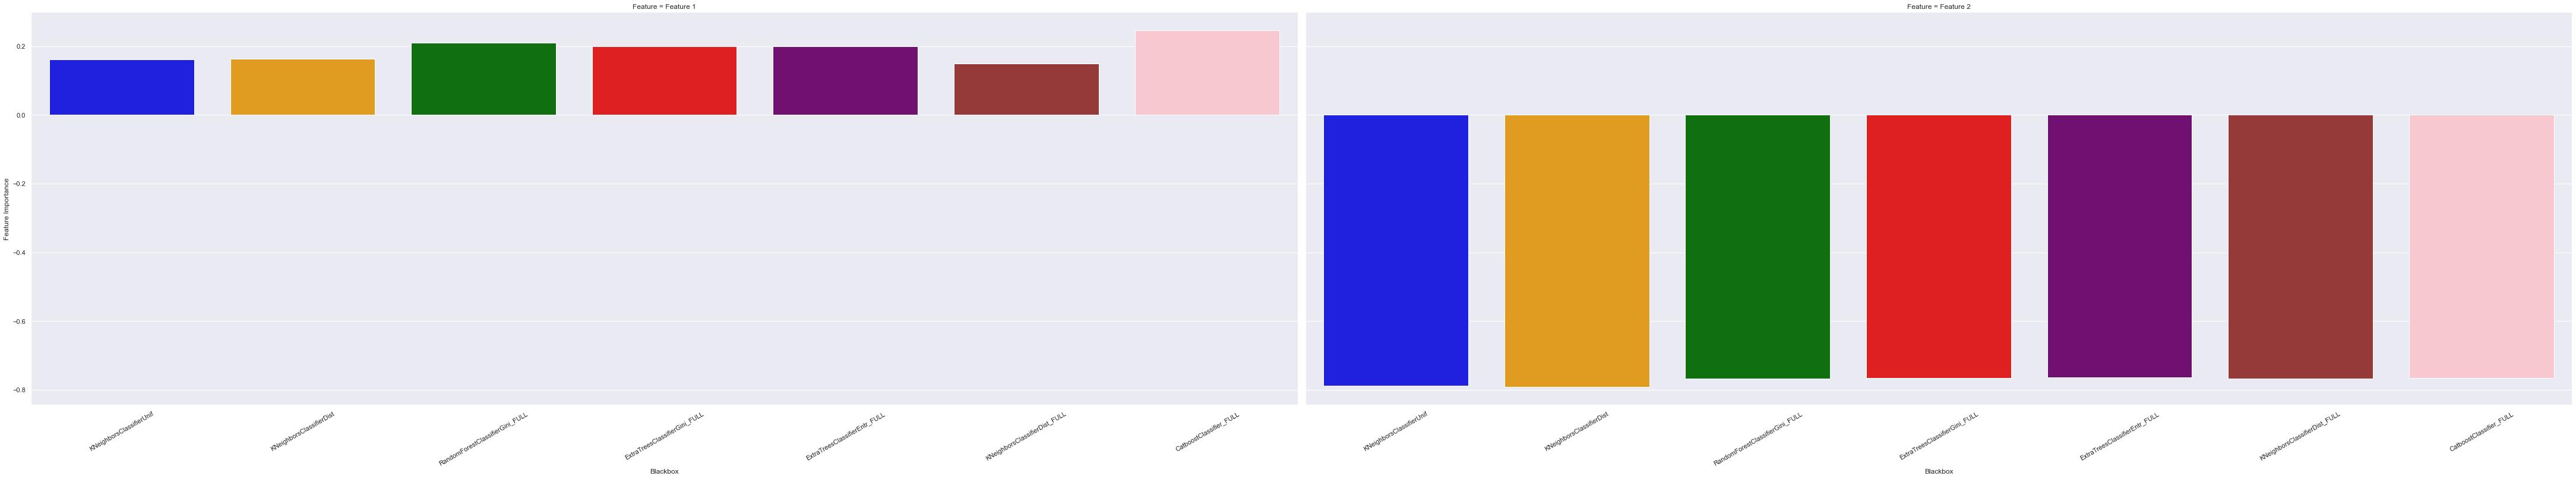

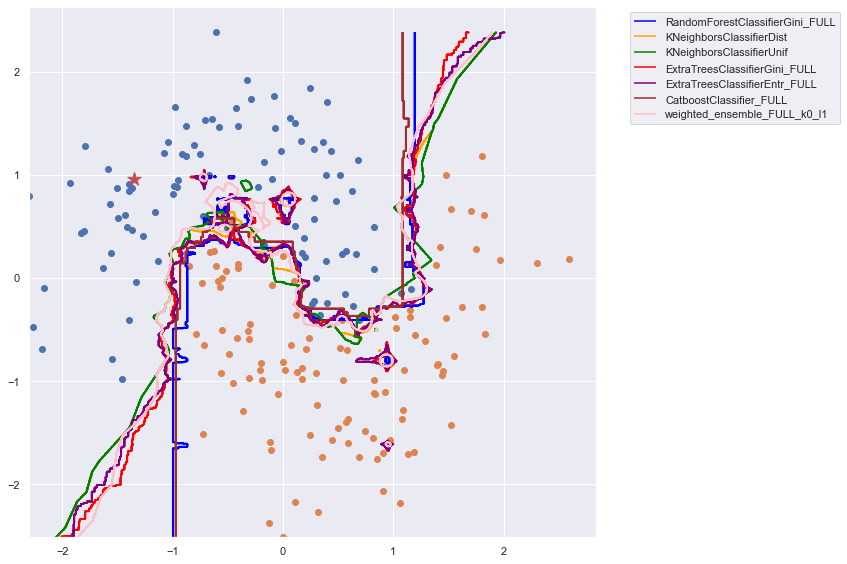

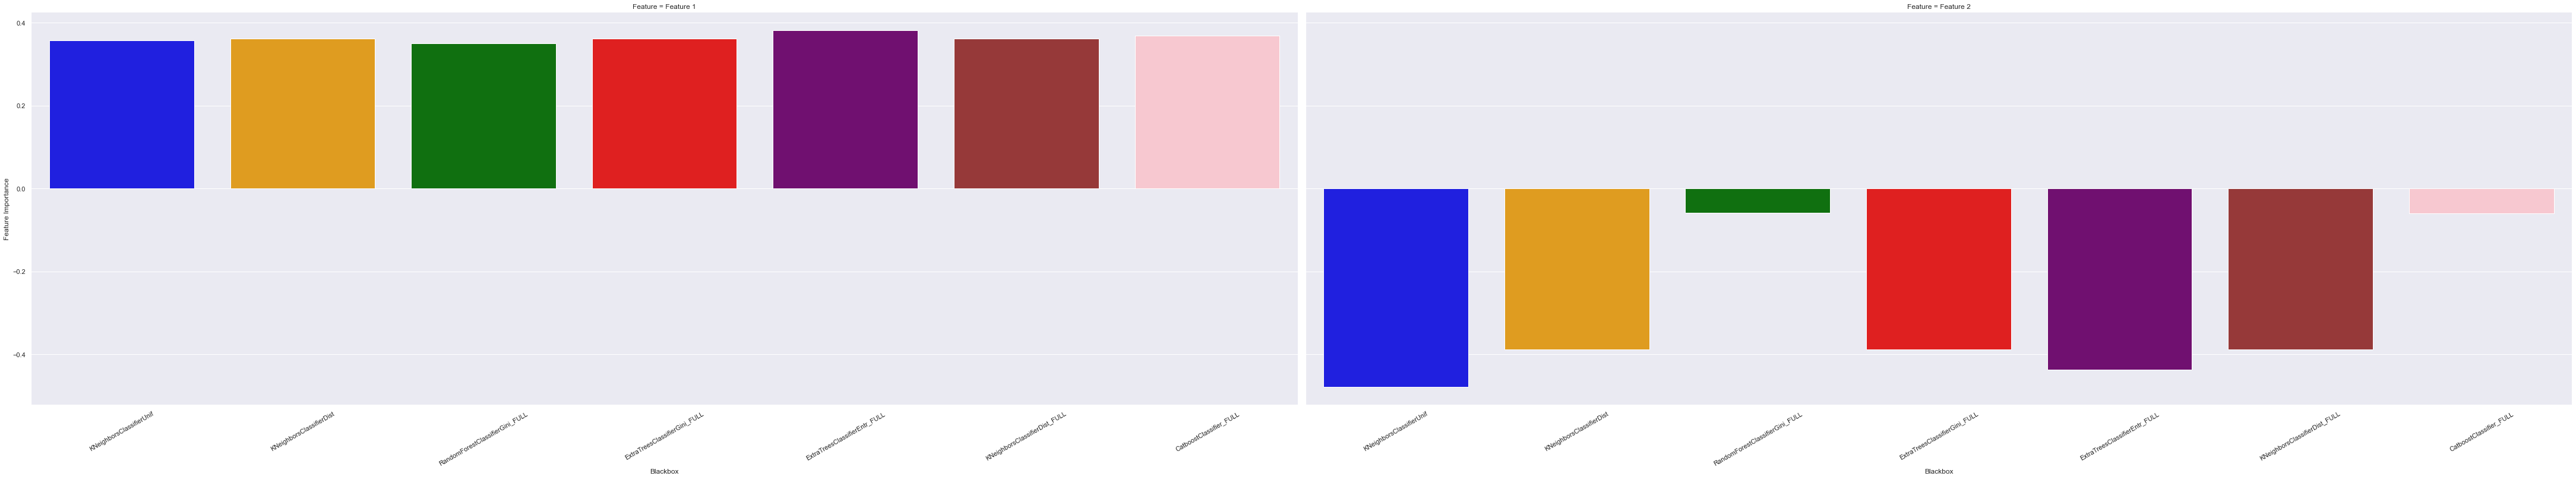

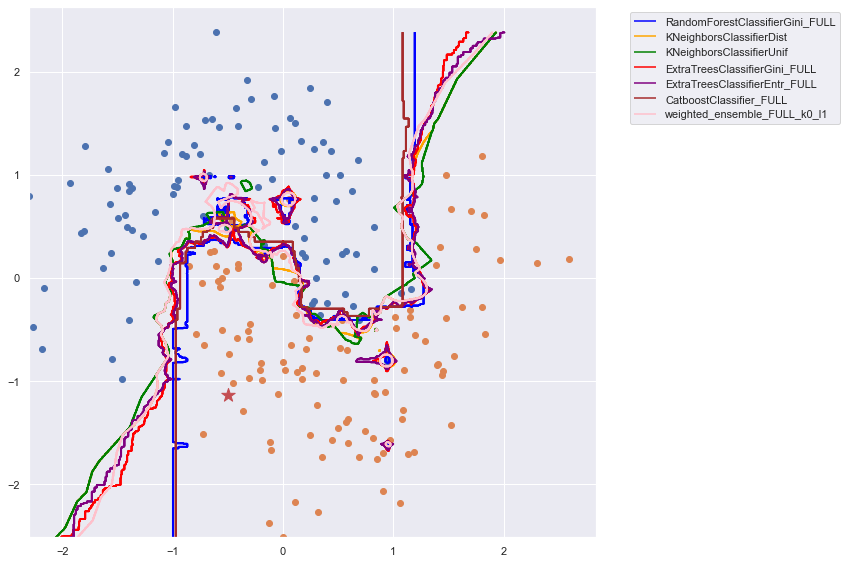

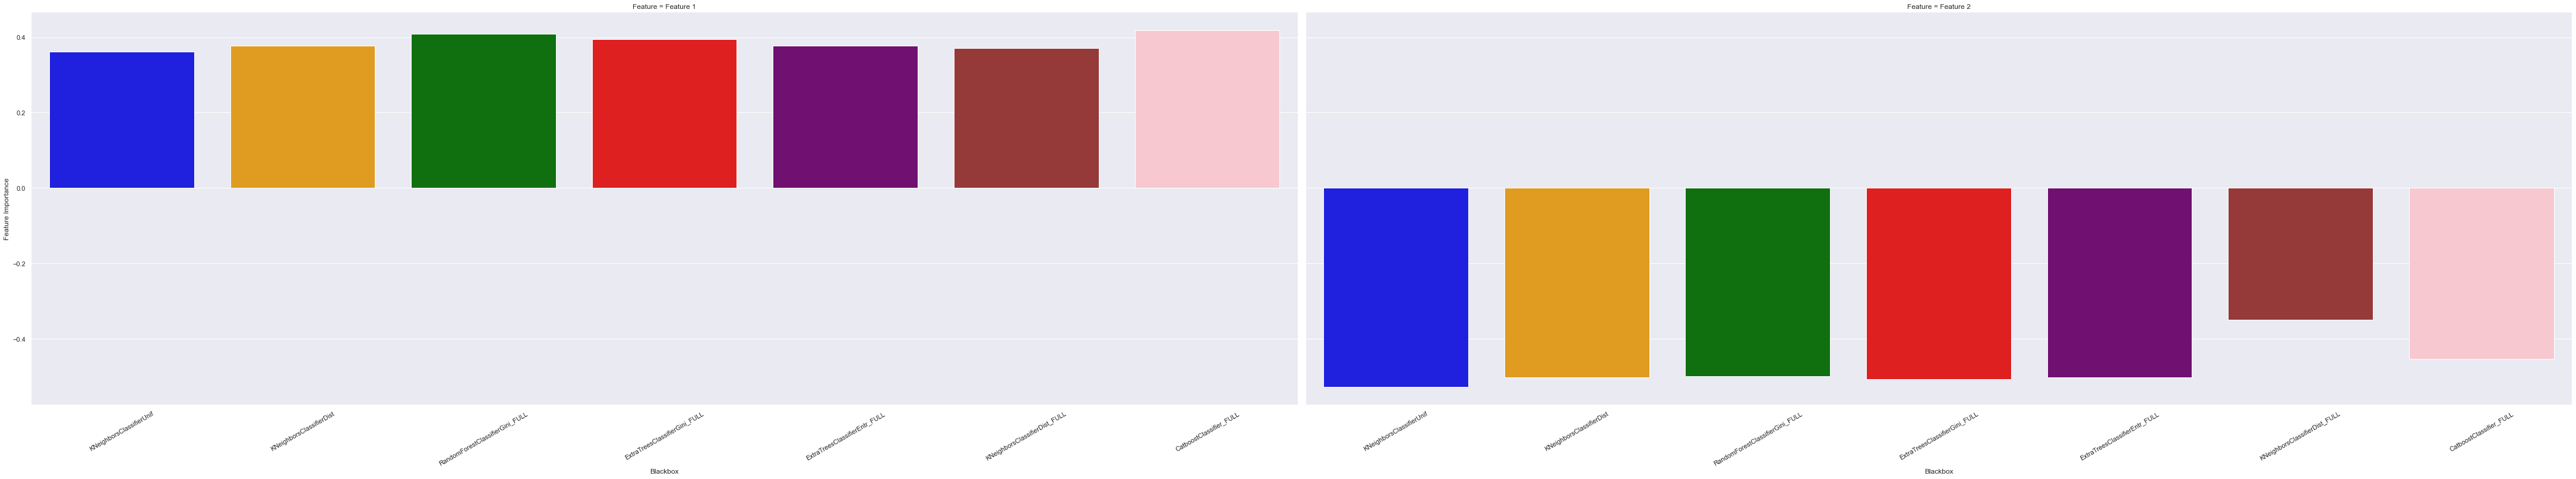

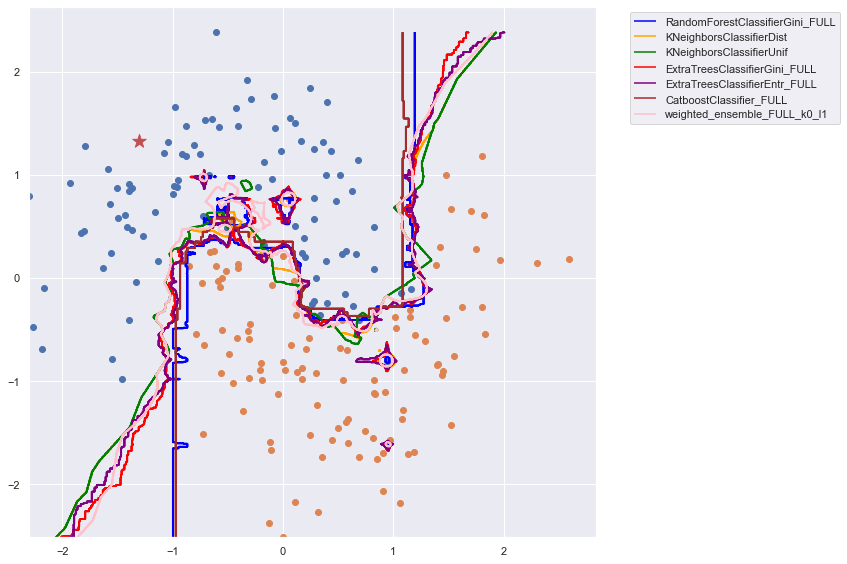

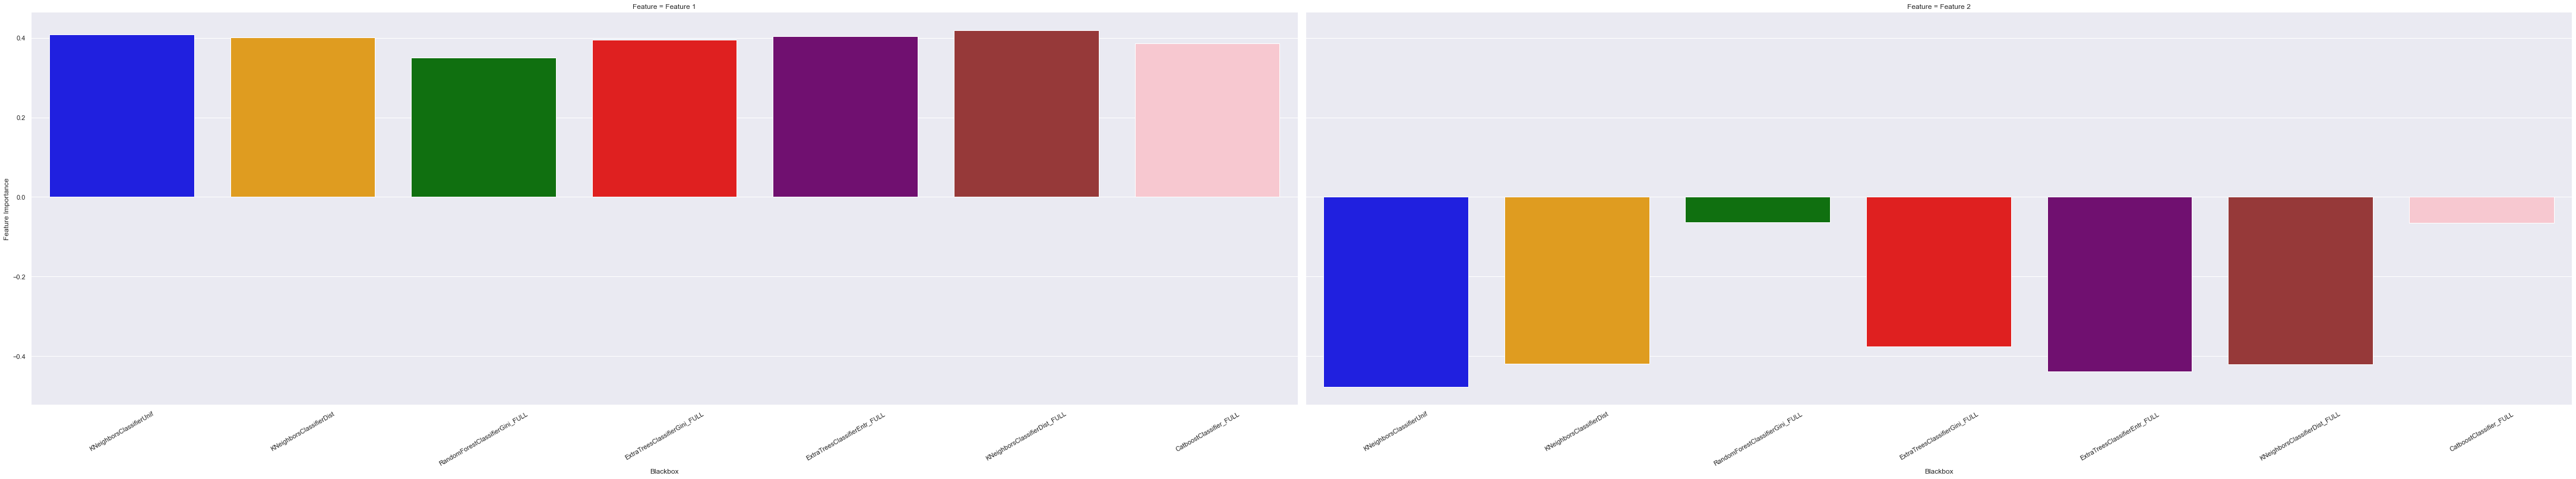

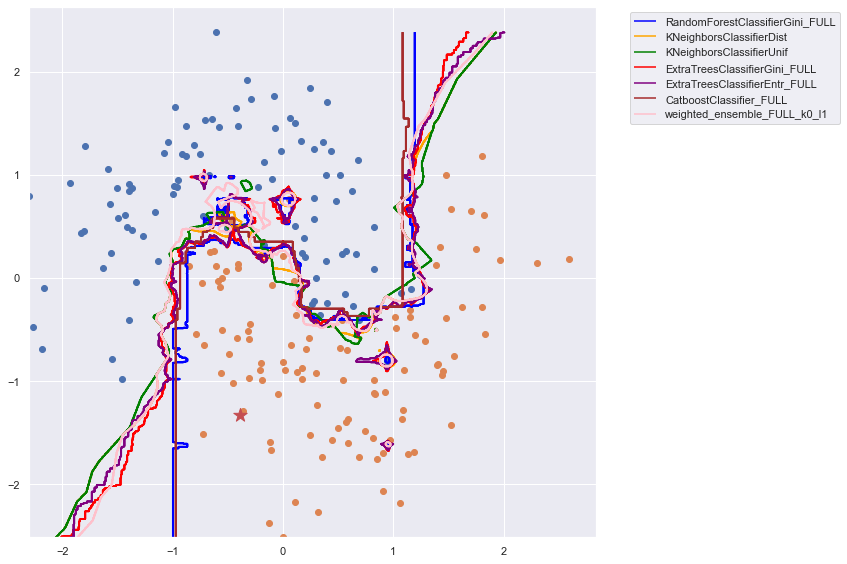

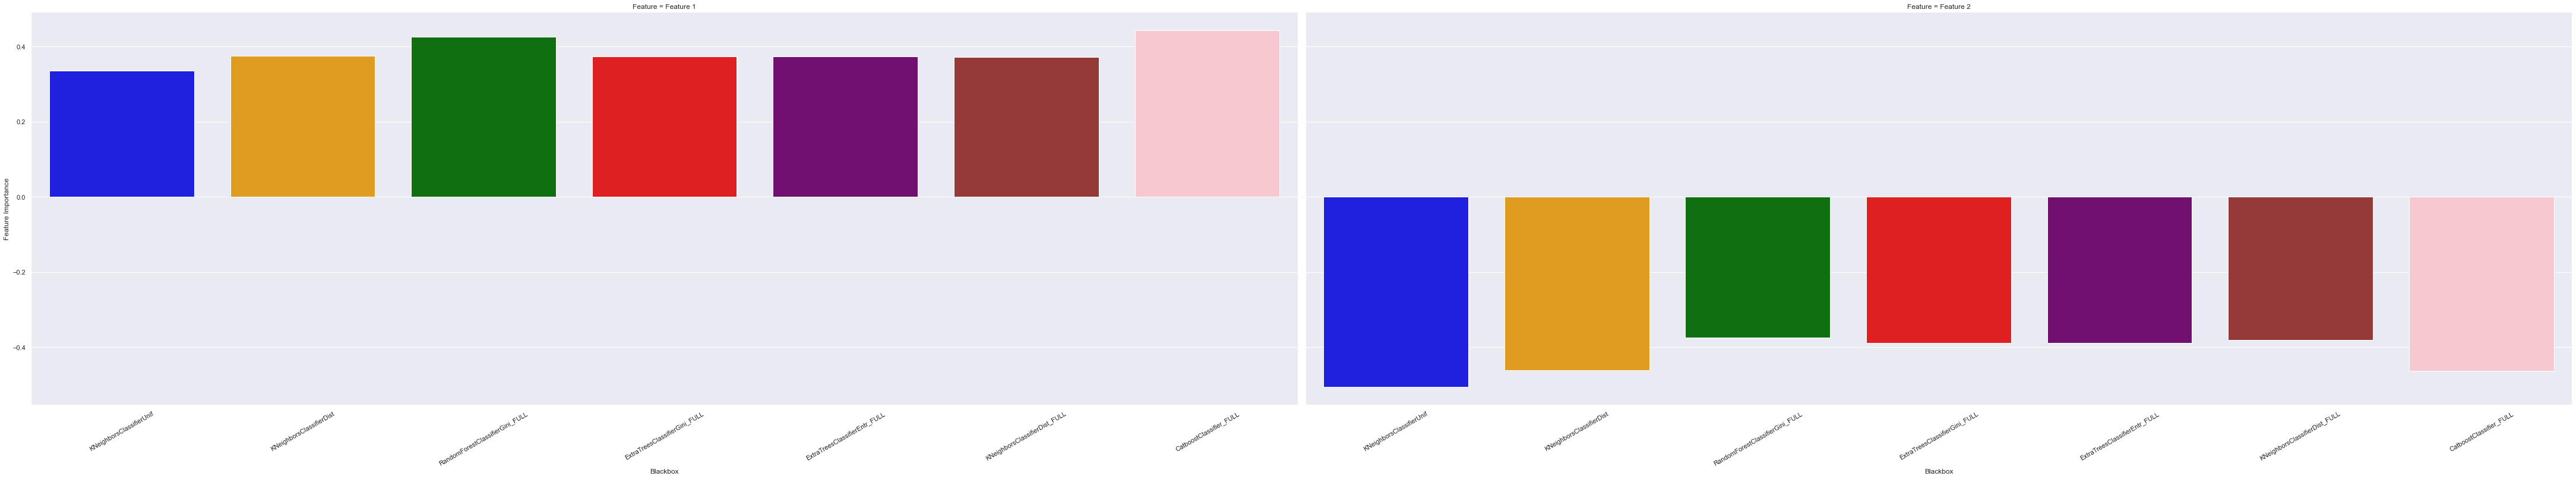

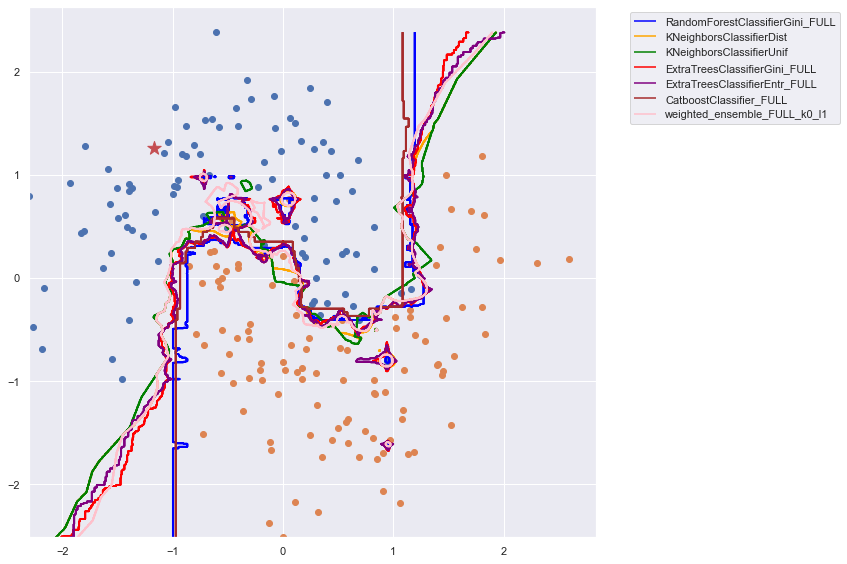

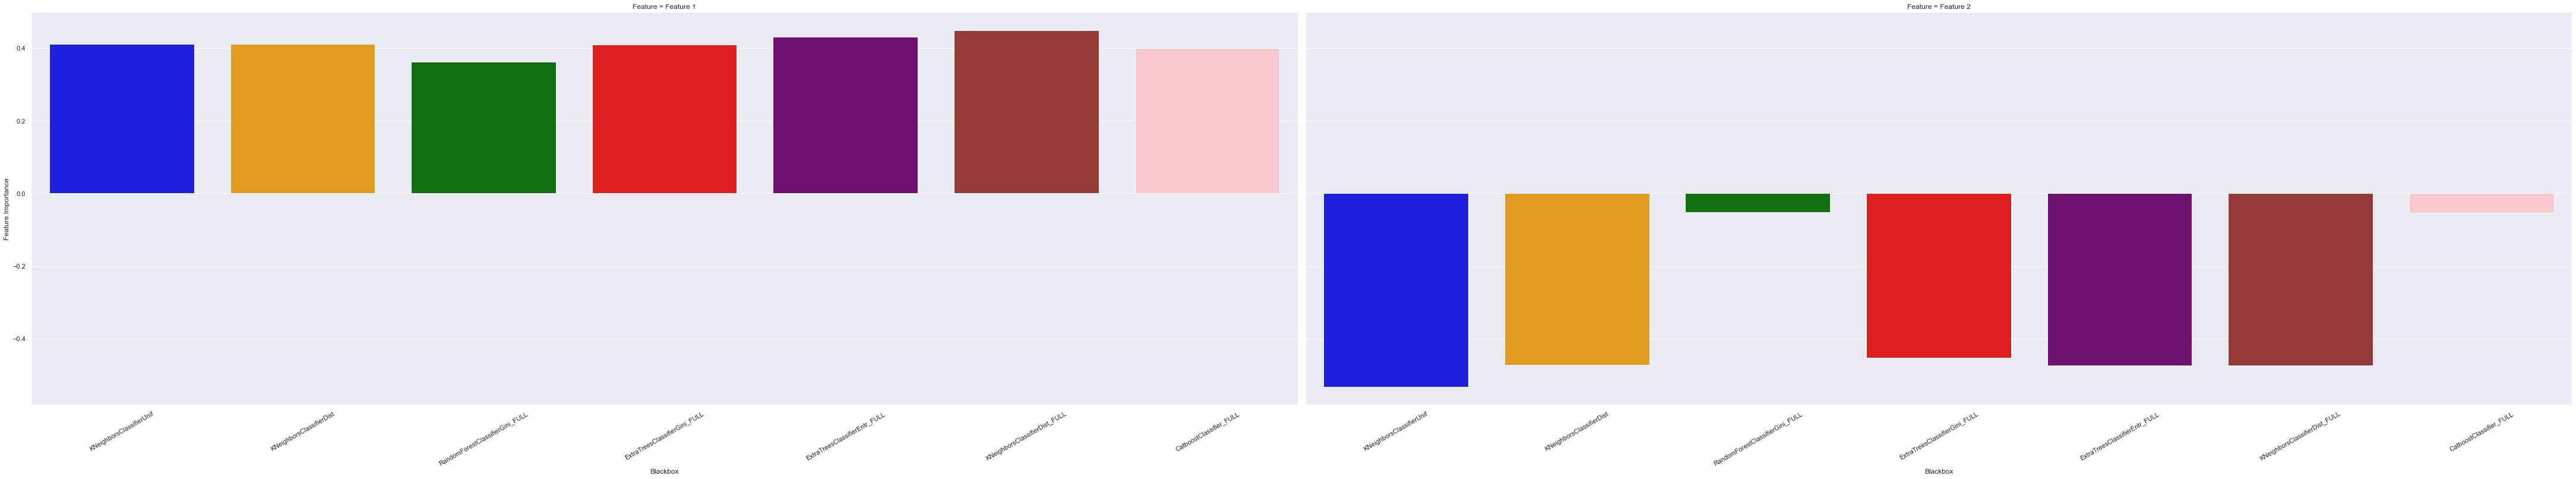

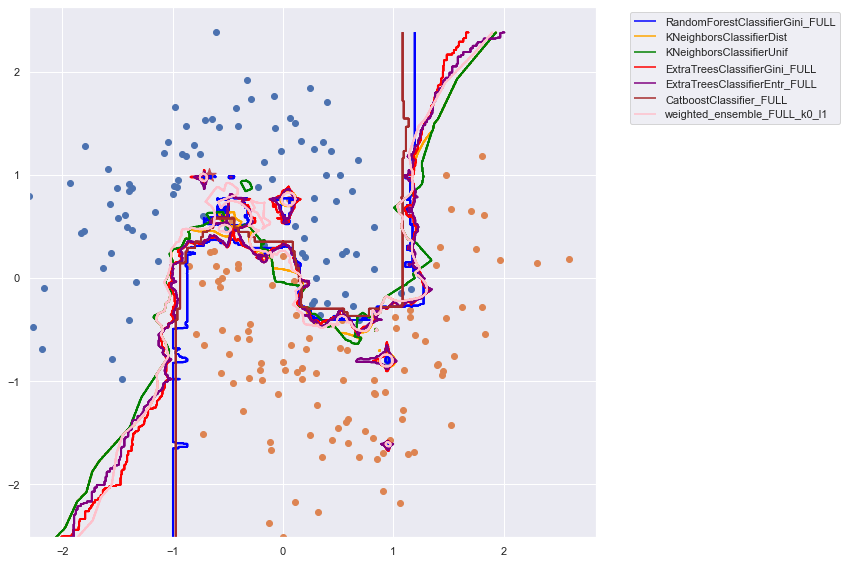

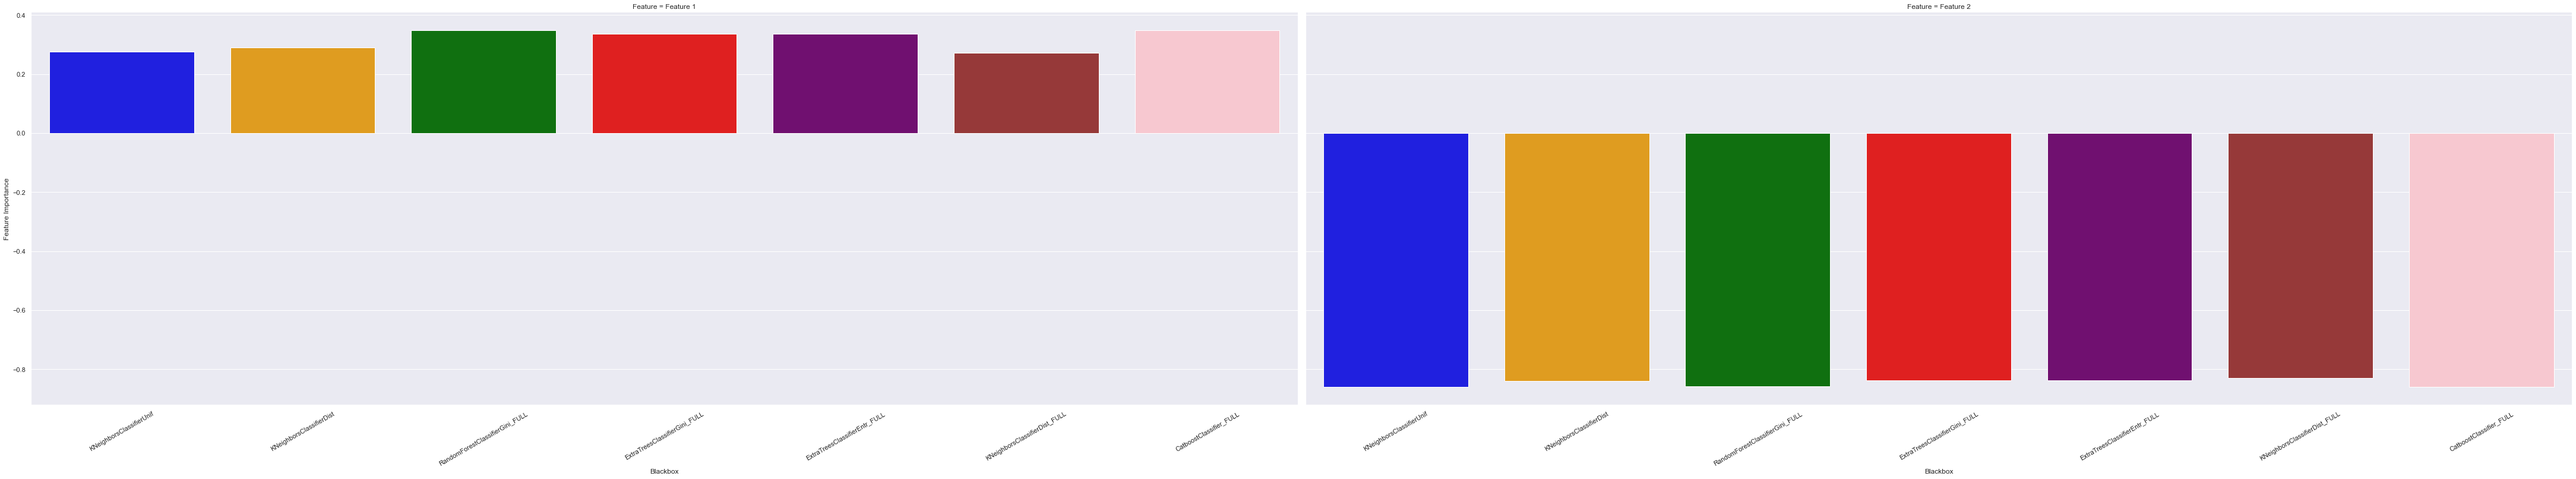

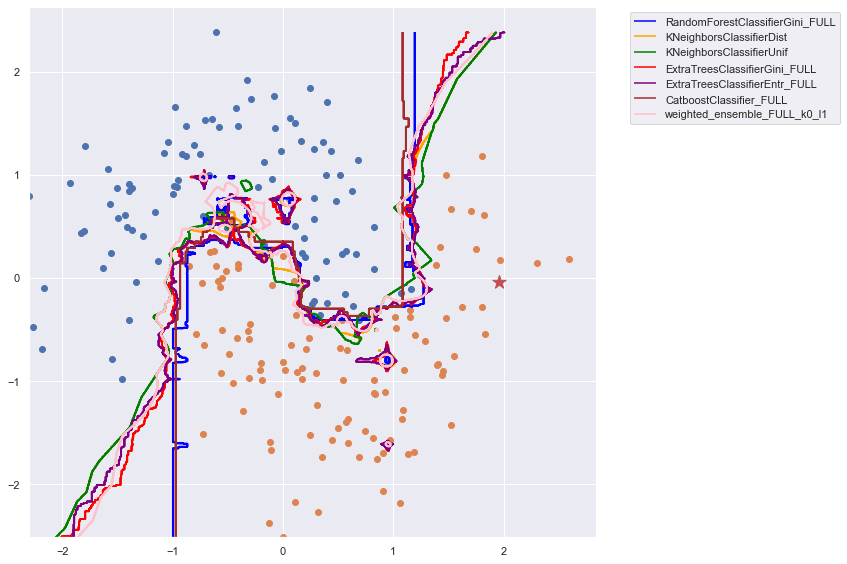

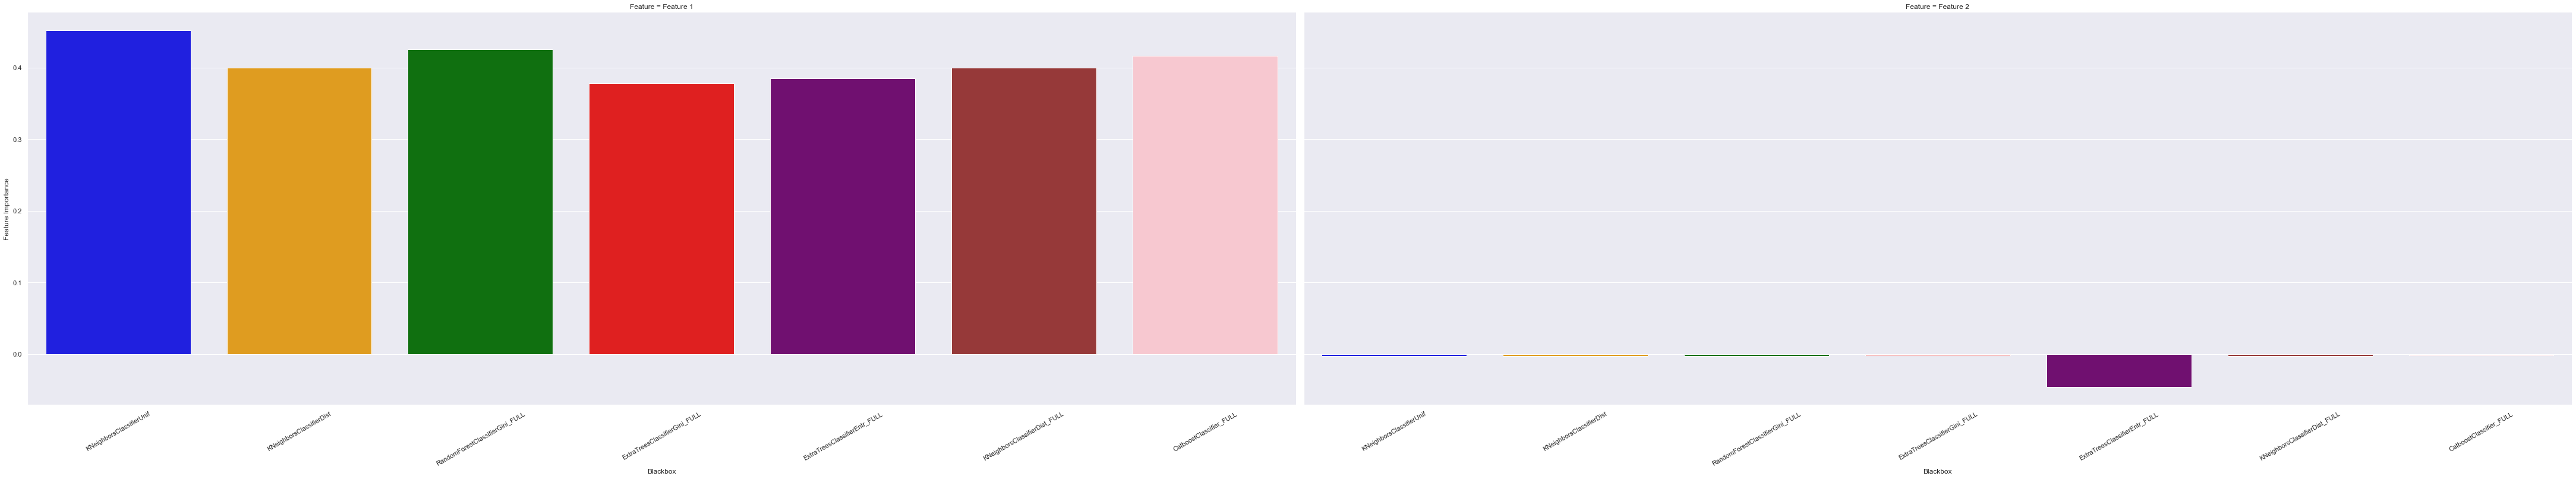

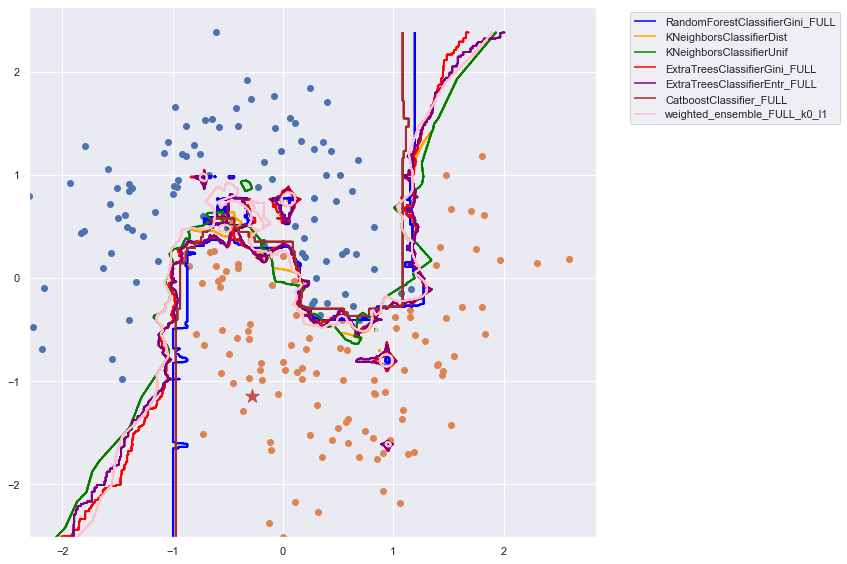

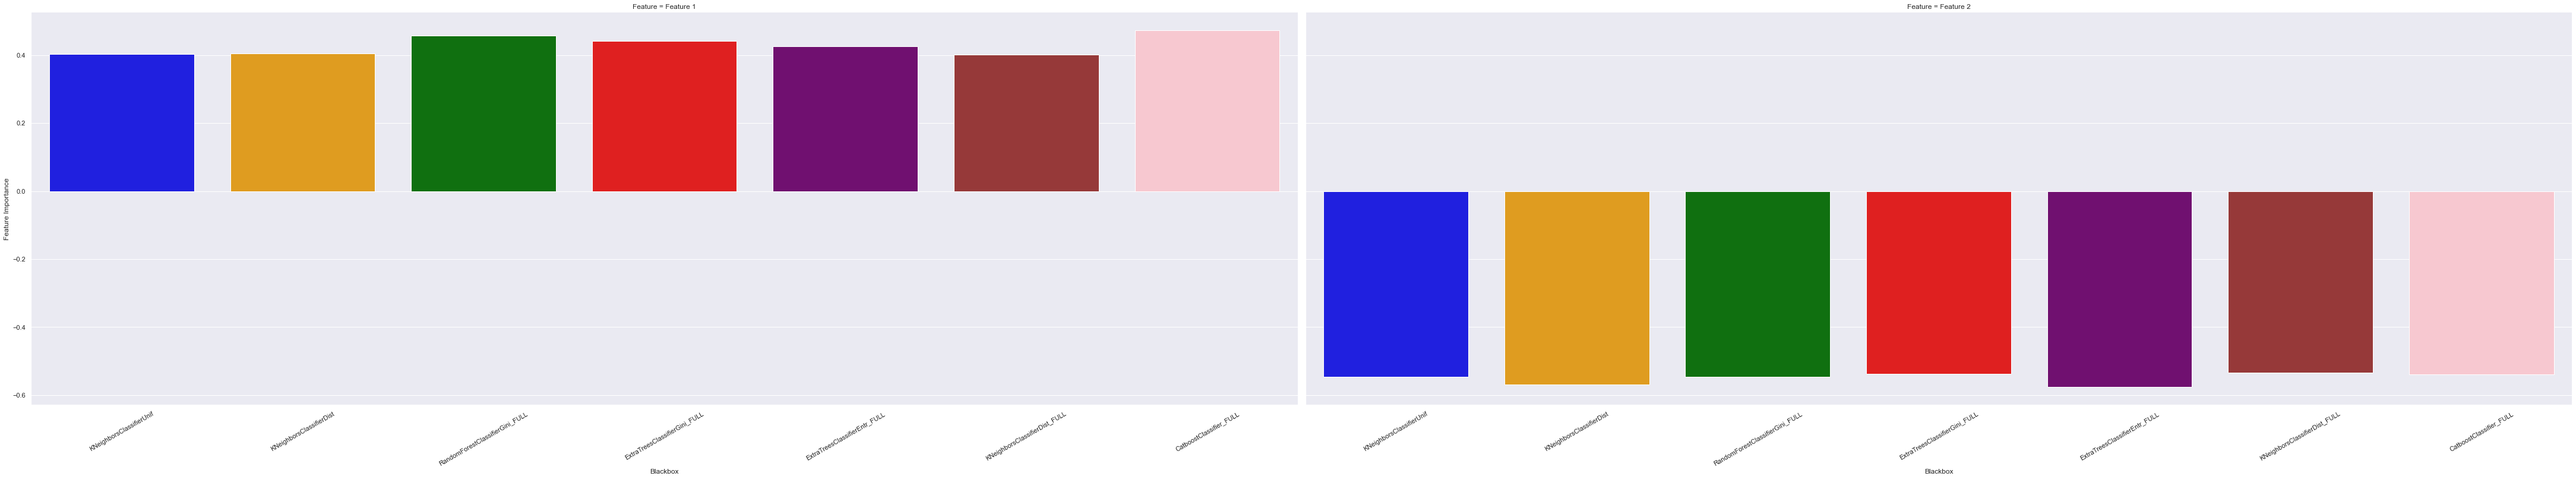

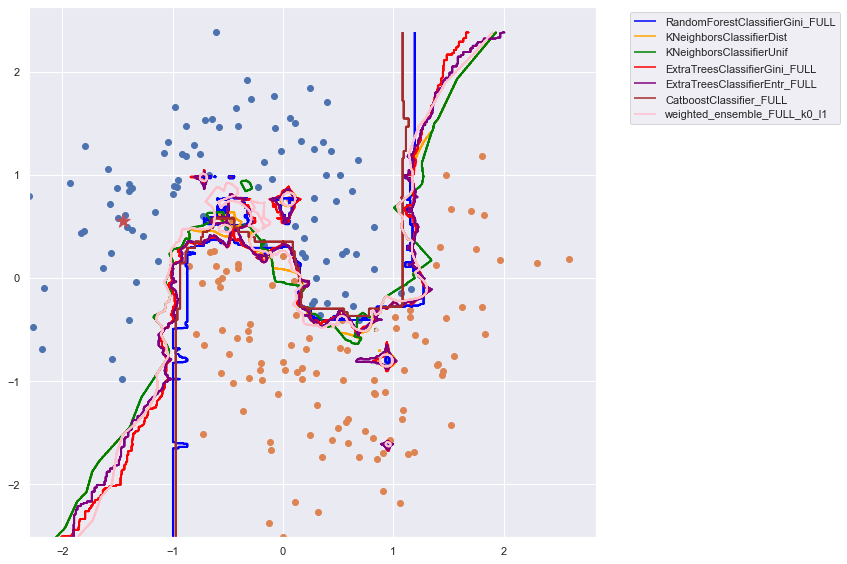

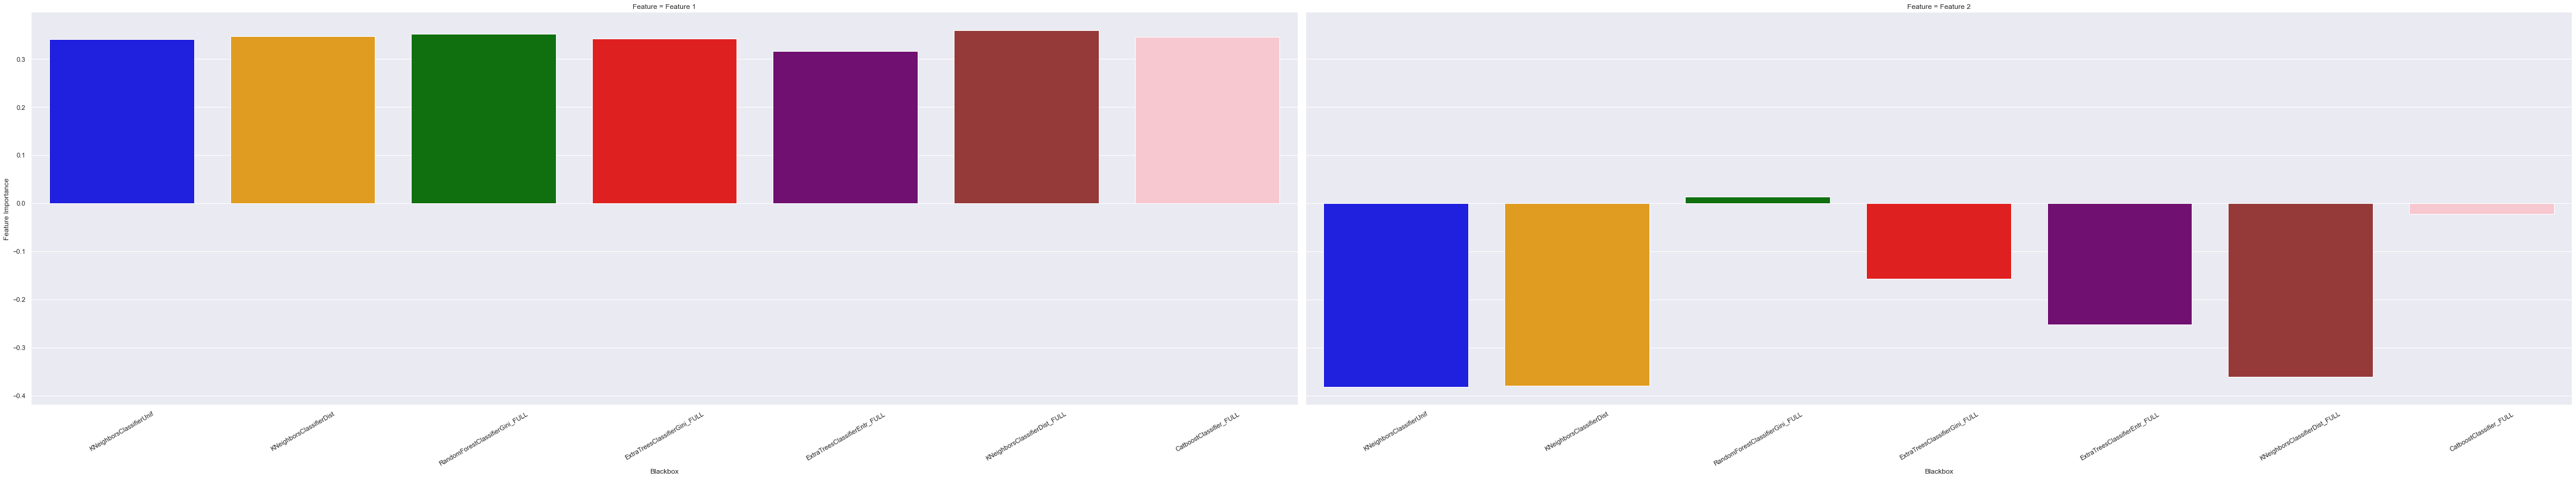

In [66]:
sns.set_context('notebook')

neighbourhood_size = 100
included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values

fis = {}

for ze in test_data.iloc[::10,:-1].iterrows():
    n_ze = ze[0]
    ze = (ze[1].to_frame().T).to_numpy()
    
    plt.figure(figsize=(12,8))
    plt.scatter(train_data[y_train==0].iloc[:,0], train_data[y_train==0].iloc[:,1])
    plt.scatter(train_data[y_train==1].iloc[:,0], train_data[y_train==1].iloc[:,1])
    
    ###### Plot Models ########################################################################################
    plots = []
    i = 0
    for p in included_blackboxes:
        preds = predictor.predict(X_tmp, model=p)
        preds = preds.reshape((xx.shape[0], yy.shape[1]))
        tmp = plt.contour(xx, yy, preds, colors=colors[i])
        plots.append(tmp)
        i += 1
    
    contours = [p.legend_elements()[0][0] for p in plots]
    plt.legend(contours, models_ranked, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    ############################################################################################################
    
    plt.scatter(ze[0,0], ze[0,1], c='r', marker='*', s=200)
    
    neigh, weights = get_shap_neigh(ze, train_data.iloc[:,:-1], autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
    ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
    surrogates, fi = fit_surrogates(neigh, ypreds_neigh)
    
    fi_unstacked = utils.plot_feature_importances_by_blackbox(fi, colors=colors)
    
    fis[n_ze] = fi_unstacked

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.084513
1         KNeighborsClassifierUnif  Feature 2           -0.443143
2         KNeighborsClassifierDist  Feature 1            0.084513
3         KNeighborsClassifierDist  Feature 2           -0.443143
4  RandomForestClassifierGini_FULL  Feature 1            0.395725


/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


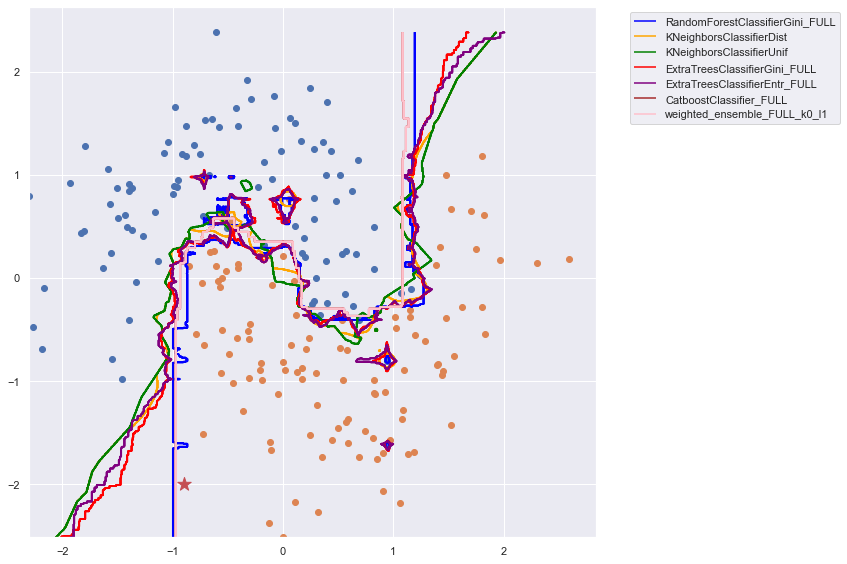

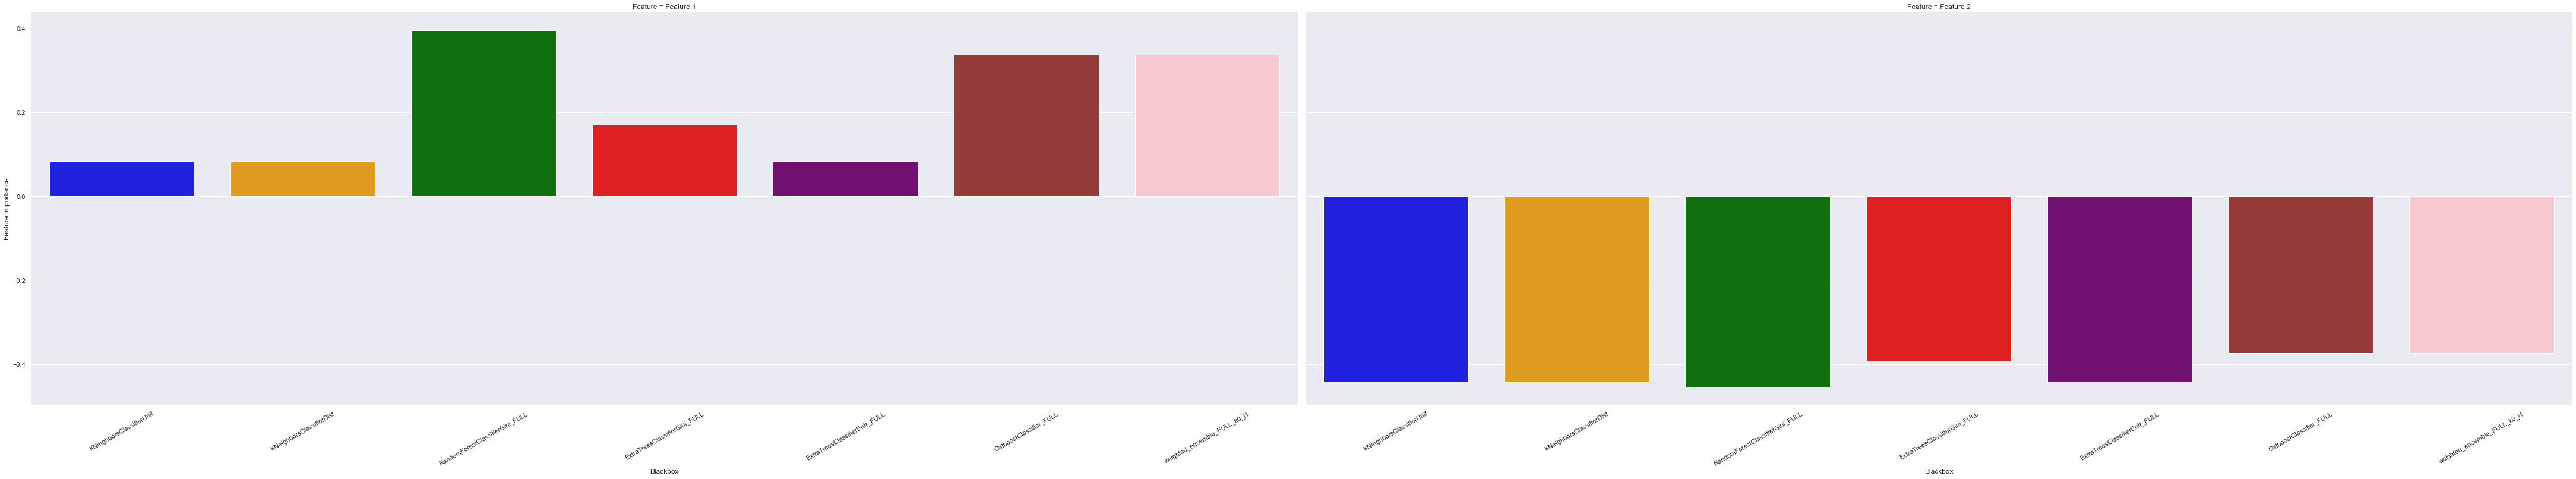

In [90]:
sns.set_context('notebook')

neighbourhood_size = 100
included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values


ze = np.array([[-0.9, -2]])

plt.figure(figsize=(12,8))
plt.scatter(train_data[y_train==0].iloc[:,0], train_data[y_train==0].iloc[:,1])
plt.scatter(train_data[y_train==1].iloc[:,0], train_data[y_train==1].iloc[:,1])

###### Plot Models ########################################################################################
plots = []
i = 0
for p in included_blackboxes:
    preds = predictor.predict(X_tmp, model=p)
    preds = preds.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds, colors=colors[i])
    plots.append(tmp)
    i += 1

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, models_ranked, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
############################################################################################################

plt.scatter(ze[0,0], ze[0,1], c='r', marker='*', s=200)

neigh, weights = get_shap_neigh(ze, train_data.iloc[:,:-1], autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
surrogates, fi = fit_surrogates(neigh, ypreds_neigh)

fi_unstacked = utils.plot_feature_importances_by_blackbox(fi, colors=colors)

/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
num_full_subsets = 1


                          Blackbox    Feature  Feature Importance
0         KNeighborsClassifierUnif  Feature 1            0.244346
1         KNeighborsClassifierUnif  Feature 2           -0.586519
2         KNeighborsClassifierDist  Feature 1            0.262477
3         KNeighborsClassifierDist  Feature 2           -0.578066
4  RandomForestClassifierGini_FULL  Feature 1            0.666991


/opt/miniconda3/envs/autogluon/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


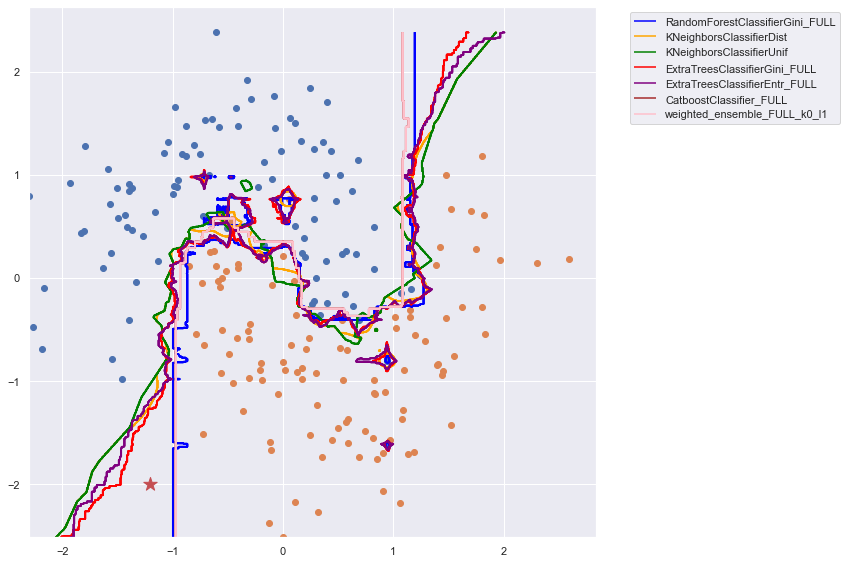

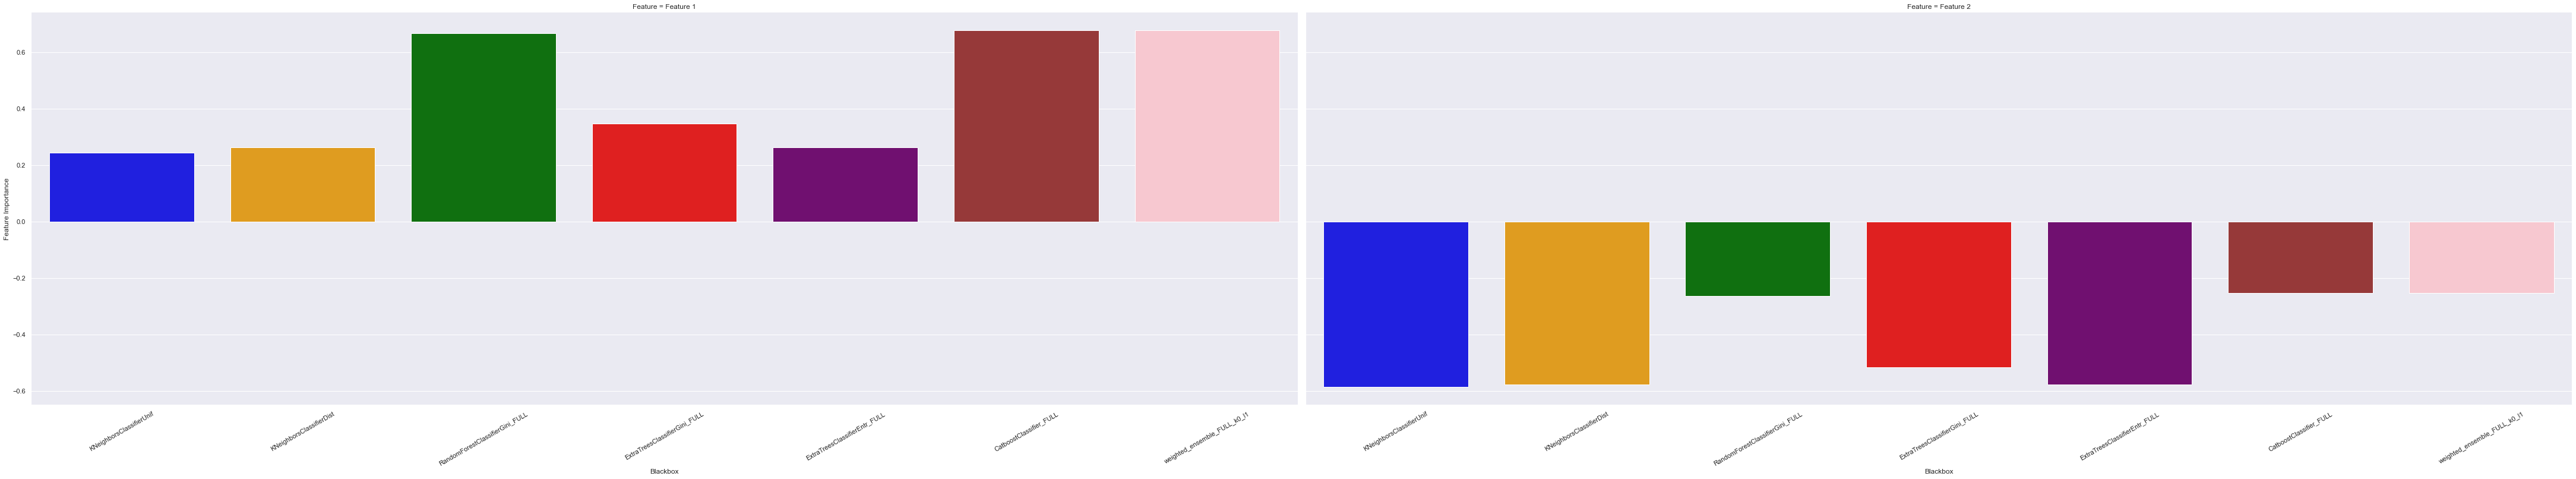

In [91]:
sns.set_context('notebook')

neighbourhood_size = 100
included_blackboxes = predictor.leaderboard(test_data, silent=True).loc[:6,'model'].values


ze = np.array([[-1.2, -2]])

plt.figure(figsize=(12,8))
plt.scatter(train_data[y_train==0].iloc[:,0], train_data[y_train==0].iloc[:,1])
plt.scatter(train_data[y_train==1].iloc[:,0], train_data[y_train==1].iloc[:,1])

###### Plot Models ########################################################################################
plots = []
i = 0
for p in included_blackboxes:
    preds = predictor.predict(X_tmp, model=p)
    preds = preds.reshape((xx.shape[0], yy.shape[1]))
    tmp = plt.contour(xx, yy, preds, colors=colors[i])
    plots.append(tmp)
    i += 1

contours = [p.legend_elements()[0][0] for p in plots]
plt.legend(contours, models_ranked, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
############################################################################################################

plt.scatter(ze[0,0], ze[0,1], c='r', marker='*', s=200)

neigh, weights = get_shap_neigh(ze, train_data.iloc[:,:-1], autogluon_blackbox_predict_proba, neigh_size=neighbourhood_size)
ypreds_neigh = get_blackboxes_predictions(predictor, neigh, included_blackboxes=included_blackboxes)
surrogates, fi = fit_surrogates(neigh, ypreds_neigh)

fi_unstacked = utils.plot_feature_importances_by_blackbox(fi, colors=colors)